# 0 Packages & Parameters

Packages

In [1]:
import pandas as pd
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
import a0_helper_functions as helper
import a1_load_crypto_prices as etl_prices
# aktuell ohne news-Auswertung
# import a2_load_crypto_news as etl_news
import a3_data_engineering as data_eng

Parameters & Pathes

In [3]:
if 'data' in os.listdir() and 'src' in os.listdir():
    notebook_folder = os.getcwd()
else:
    notebook_folder = os.path.dirname(os.getcwd())

In [4]:
path_prices_long = os.path.join(notebook_folder, 'data', 'crypto_prices_hourly_v241117.csv')

In [5]:
bool_reload_prices = False

# Define the symbols
dict_symbols = {
    'Bitcoin': 'BTC/USD',
    'Ether': 'ETH/USD',
    'Solana': 'SOL/USD',
    'Ripple': 'XRP/USD',
    'Fetch.ai': 'FET/USD',
    'NEAR': 'NEAR/USD',
    'Chainlink': 'LINK/USD',
    'Aave': 'AAVE/USD',
    'Avalanche': 'AVAX/USD',
    'Polygon': 'MATIC/USD',
    'Litecoin': 'LTC/USD',
    'Cardano': 'ADA/USD',
    'Polkadot': 'DOT/USD',
    #'Fantom': 'FTM/USD',
    #'TRON': 'TRX/USD',
    'Hedera': 'HBAR/USD',
    'Bitcoin Cash': 'BCH/USD',
    'The Graph': 'GRT/USD',
    'Stellar': 'XLM/USD',
    'Algorand': 'ALGO/USD',
    'Maker': 'MKR/USD',
    'Uniswap': 'UNI/USD',
    'SUI': 'SUI/USD',
    'MATH': 'MATH/USD',
    'ApeCoin': 'APE/USD',
    'Aptos': 'APT/USD',
    'Arbitrum': 'ARB/USD',
    'Kaspa': 'KAS/USD',
    'Mantle': 'MNT/USD',
    'Immutable': 'IMX/USD',
    'district0x': 'DNT/USD',
    'Stader': 'SD/USD',
    'Clover Finance': 'CLV/USD',
    'MANTRA DAO': 'OM/USD',
    'Bonk': 'BONK/USD',
    'Quant': 'QNT/USD',
    'dogwifhat': 'DOGWIFHAT/USD',
    'The Sandbox': 'SAND/USD',
    'PEPE': 'PEPE/USD',
    'vechain': 'VET/USD',
    'Cosmos': 'ATOM/USD',
    'Optimism': 'OP/USD',
    'Sei': 'SEI/USD',
    'Celestia': 'TIA/USD',
    'Flare': 'FLR/USD',
    'Helium': 'HNT/USD',
    'Kava': 'KAVA/USD'
}

symbols_coinbase = [v for v in dict_symbols.values()]
symbols_news = [k for k in dict_symbols.keys()]
day_apply = '2024-10-01'

In [6]:
# Get today's date
today = datetime.now().date()
# Convert day_apply to datetime object
day_apply_date = datetime.strptime(day_apply, '%Y-%m-%d').date()
# Calculate the number of days between today and day_apply
num_days_apply = (today-day_apply_date).days

Loader objects

In [7]:
etl_prices_long = etl_prices.CryptoPriceLoader(symbols=symbols_coinbase, timeframe='1d', days_ago=1500)
etl_prices_apply = etl_prices.CryptoPriceLoader(symbols=symbols_coinbase, timeframe='1d', days_ago=num_days_apply)

# 1 Fetch data

1a etl crypto prices

In [8]:
# Long-term prices (past)
if (not os.path.exists(path_prices_long)) | (bool_reload_prices == True):
    df_prices_long = etl_prices_long.fetch_prepare_crypto_prices(prepare=False)
    df_prices_long.to_csv(path_prices_long, index = False)
else:
    df_prices_long = pd.read_csv(path_prices_long)

df_prices_long['day'] = pd.to_datetime(df_prices_long['day'])

In [9]:
# Apply timeframe (last days since day_apply)
df_prices_apply = etl_prices_apply.fetch_prepare_crypto_prices(prepare=False)

BTC/USD
ETH/USD
SOL/USD
XRP/USD
FET/USD
NEAR/USD
LINK/USD
AAVE/USD
AVAX/USD
MATIC/USD
LTC/USD
ADA/USD
DOT/USD
HBAR/USD
BCH/USD
GRT/USD
XLM/USD
ALGO/USD
MKR/USD
UNI/USD
SUI/USD
MATH/USD
APE/USD
APT/USD
ARB/USD
KAS/USD
Error fetching KAS/USD: coinbase does not have market symbol KAS/USD
MNT/USD
Error fetching MNT/USD: coinbase does not have market symbol MNT/USD
IMX/USD
DNT/USD
SD/USD
CLV/USD
OM/USD
Error fetching OM/USD: coinbase does not have market symbol OM/USD
BONK/USD
QNT/USD
DOGWIFHAT/USD
Error fetching DOGWIFHAT/USD: coinbase does not have market symbol DOGWIFHAT/USD
SAND/USD
PEPE/USD
VET/USD
ATOM/USD
OP/USD
SEI/USD
TIA/USD
FLR/USD
HNT/USD
KAVA/USD


# 2 Data Engineering

### 2.1 Standard features

In [10]:
# Combine datasets
df_prices_combined = pd.concat([df_prices_long.loc[df_prices_long['day'] < day_apply], df_prices_apply], axis=0)

In [11]:
# Calculate relative prices to Bitcoin
df_all_coins = data_eng.calculate_relative_price_to_btc(df = df_prices_combined)

In [12]:
# Calculate average prices over the last 3 days to smooth the data
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'price', colname_new = 'avg_price_', window_length = 3, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'price_relative_to_btc', colname_new = 'avg_rel_price_', window_length = 3, col_group = 'coin', col_sort = 'day')

In [13]:
# calculate additional average to define momentum
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'price', colname_new = 'avg_price_', window_length = 5, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'price', colname_new = 'avg_price_', window_length = 10, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'price', colname_new = 'avg_price_', window_length = 15, col_group = 'coin', col_sort = 'day')

In [14]:
# volume - calculate additional average to define momentum
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'volume', colname_new = 'avg_volume_', window_length = 5, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'volume', colname_new = 'avg_volume_', window_length = 10, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'volume', colname_new = 'avg_volume_', window_length = 15, col_group = 'coin', col_sort = 'day')

In [15]:
# volume_usd - calculate additional average to define momentum
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'volume_usd', colname_new = 'avg_volume_usd_', window_length = 5, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'volume_usd', colname_new = 'avg_volume_usd_', window_length = 10, col_group = 'coin', col_sort = 'day')
df_all_coins = data_eng.weighted_average(df_all_coins, col_price = 'volume_usd', colname_new = 'avg_volume_usd_', window_length = 15, col_group = 'coin', col_sort = 'day')

### 2.2 Logic-based variables

In [16]:
# split data again to calculate local minima and maxima only on past data to better see if the approaches will work
df_train = df_all_coins.loc[(df_all_coins['day']< day_apply) & (df_all_coins['day']> '2021-01-01')]
df_apply = df_all_coins.loc[(df_all_coins['day']>= day_apply)]

In [17]:
# Support and resistance levels
df_train = data_eng.define_local_min_max2(df_train, col_price_min = 'low', col_price_max = 'high', period_window_min_max = 5, col_sort = 'day')
df_train = data_eng.aggregate_support_levels(df = df_train, col_min = 'local_min', col_max = 'local_max', col_group='coin', 
                                             col_price='price', suffix = '', thres = 0.01)
# combine again
df_all_coins2 = pd.concat([df_train, df_apply])

c:\Users\Hubertus Melsheimer\OneDrive - McKinsey & Company\Documents\Privat\Python_Projekte\Crypto\src\a3_data_engineering.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by = col_sort, inplace = True)
c:\Users\Hubertus Melsheimer\OneDrive - McKinsey & Company\Documents\Privat\Python_Projekte\Crypto\src\a3_data_engineering.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_max] = df.groupby(col_group)[col_price_max].transform(lambda d: d.rolling(window=period_window_min_max, min_periods=period_window_min_max, center=True).max())
c:\Us

In [18]:
# find next support and resistance levels
df_levels = df_train[['coin','price_level', 'counter_level']].drop_duplicates().sort_values(by = 'price_level', ascending = True)

df_all_coins2['price_level_below'] = df_all_coins2.apply(lambda row: data_eng.find_level(row, df_levels, direction='below', n = 1, col_find='price_level'), axis=1) 
df_all_coins2['price_level_below2'] = df_all_coins2.apply(lambda row: data_eng.find_level(row, df_levels, direction='below', n = 2, col_find='price_level'), axis=1) 
df_all_coins2['price_level_below3'] = df_all_coins2.apply(lambda row: data_eng.find_level(row, df_levels, direction='below', n = 3, col_find='price_level'), axis=1) 
df_all_coins2['price_level_above'] = df_all_coins2.apply(lambda row: data_eng.find_level(row, df_levels, direction='above', n = 1, col_find='price_level'), axis=1) 
df_all_coins2['price_level_above2'] = df_all_coins2.apply(lambda row: data_eng.find_level(row, df_levels, direction='above', n = 2, col_find='price_level'), axis=1) 
df_all_coins2['price_level_above3'] = df_all_coins2.apply(lambda row: data_eng.find_level(row, df_levels, direction='above', n = 3, col_find='price_level'), axis=1) 

In [19]:
df_all_coins2['delta_to level_below'] = df_all_coins2['price'] - df_all_coins2['price_level_below']
df_all_coins2['delta_to level_above'] = df_all_coins2['price_level_above'] - df_all_coins2['price']
df_all_coins2['delta_to level_below2'] = df_all_coins2['price'] - df_all_coins2['price_level_below2']
df_all_coins2['delta_to level_above2'] = df_all_coins2['price_level_above2'] - df_all_coins2['price']
df_all_coins2['delta_to level_below3'] = df_all_coins2['price'] - df_all_coins2['price_level_below3']
df_all_coins2['delta_to level_above3'] = df_all_coins2['price_level_above3'] - df_all_coins2['price']

In [20]:
# calculate momentum
df_all_coins2 = data_eng.calculate_momentum(df_all_coins2, 'momentum_price', 'avg_price_3', 'avg_price_5', 'avg_price_10', 'avg_price_15')
df_all_coins2 = data_eng.weighted_average(df_all_coins2, col_price = 'momentum_price', colname_new = 'momentum_price_', window_length = 5, col_group = 'coin', col_sort='day')
df_all_coins2 = data_eng.calculate_momentum(df_all_coins2, 'momentum_volume', 'volume', 'avg_volume_5', 'avg_volume_10', 'avg_volume_15')
df_all_coins2 = data_eng.weighted_average(df_all_coins2, col_price = 'momentum_volume', colname_new = 'momentum_volume_', window_length = 5, col_group = 'coin', col_sort='day')
df_all_coins2 = data_eng.calculate_momentum(df_all_coins2, 'momentum_volume_usd', 'volume_usd', 'avg_volume_usd_5', 'avg_volume_usd_10', 'avg_volume_usd_15')
df_all_coins2 = data_eng.weighted_average(df_all_coins2, col_price = 'momentum_volume_usd', colname_new = 'momentum_volume_usd_', window_length = 5, col_group = 'coin', col_sort='day')

In [21]:
# simple sanity check
df_all_coins2.groupby('coin', as_index = False).volume_usd.sum().sort_values(by = 'volume_usd', ascending = False).head(10)

coin    volume_usd
10    BTC/USD  9.543034e+11
14    ETH/USD  6.258270e+11
34    SOL/USD  1.539209e+11
1     ADA/USD  8.589179e+10
25  MATIC/USD  6.700261e+10
22   LINK/USD  6.255183e+10
23    LTC/USD  5.237699e+10
7    AVAX/USD  4.273655e+10
39    XLM/USD  4.145067e+10
6    ATOM/USD  3.013074e+10

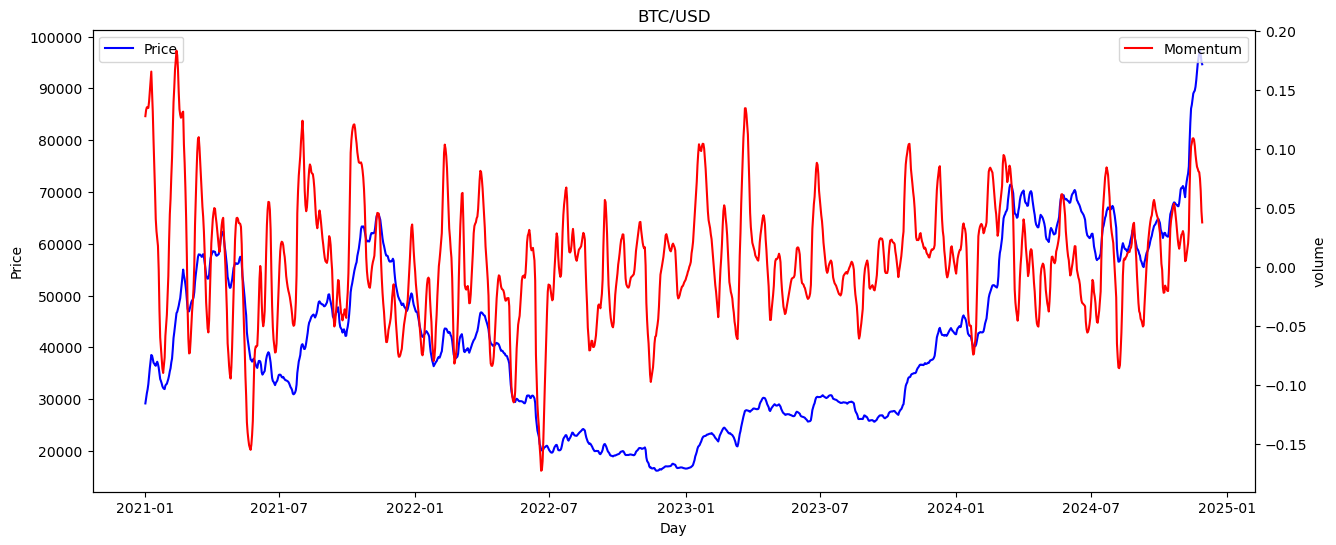

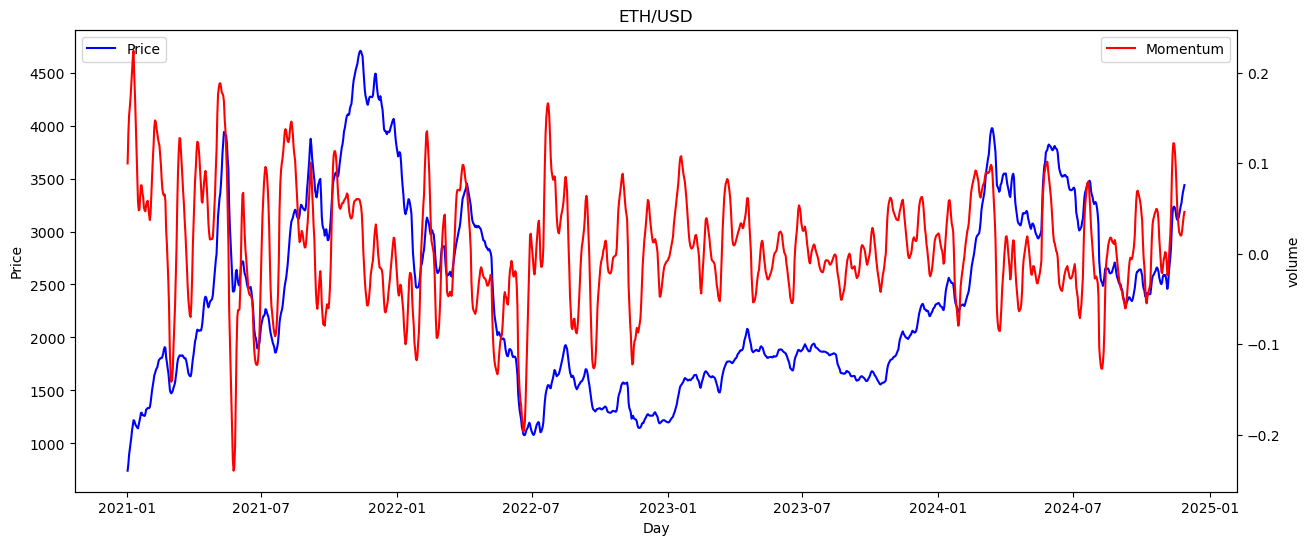

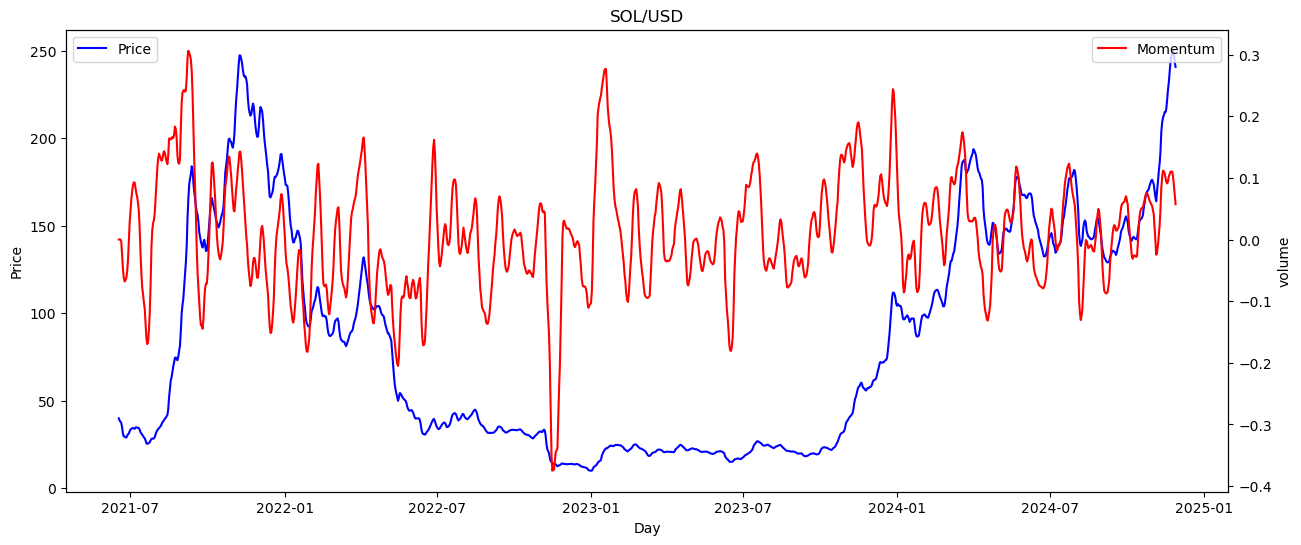

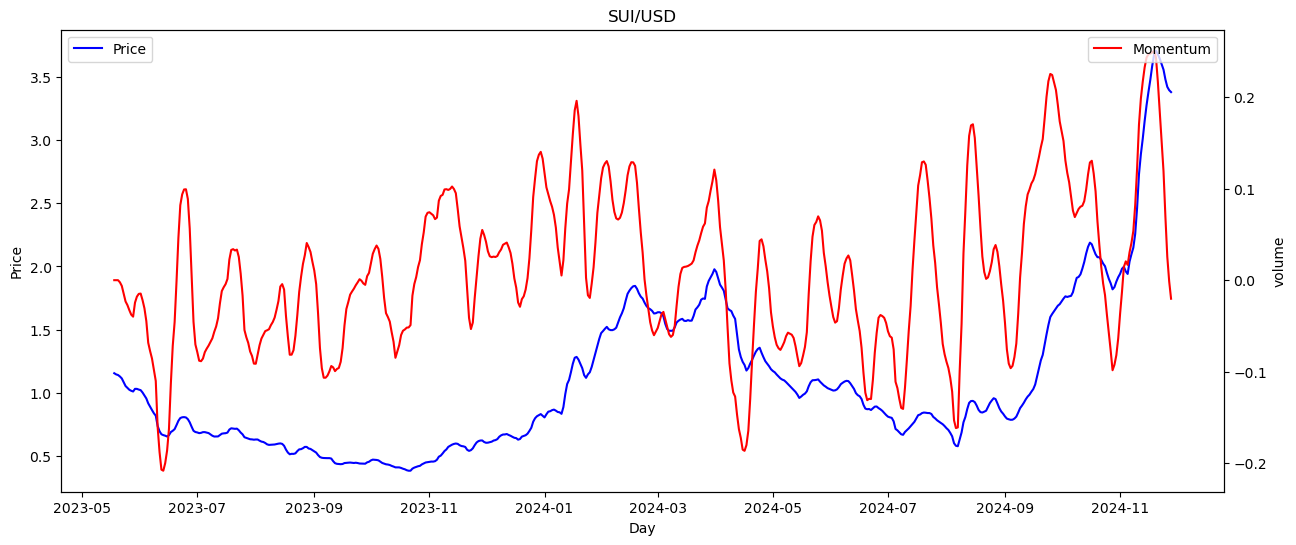

In [22]:
# Plot Momentum vs Price
for cc in ['BTC/USD', 'ETH/USD', 'SOL/USD', 'SUI/USD']:#, 'ALGO/USD', 'APE/USD','IMX/USD', 'MKR/USD', 'MATH/USD', 'POL/USD']:
    df_coin = df_all_coins2.loc[df_all_coins2['coin'] == cc]
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax2 = ax1.twinx()
    #ax3 = ax1.twinx()
    ax1.plot(df_coin['day'], df_coin['avg_price_5'], color='blue', label='Price')
    ax2.plot(df_coin['day'], df_coin['momentum_price_5'], color='red', label='Momentum')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Price')
    ax2.set_ylabel('volume')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_title(cc)
    plt.show()

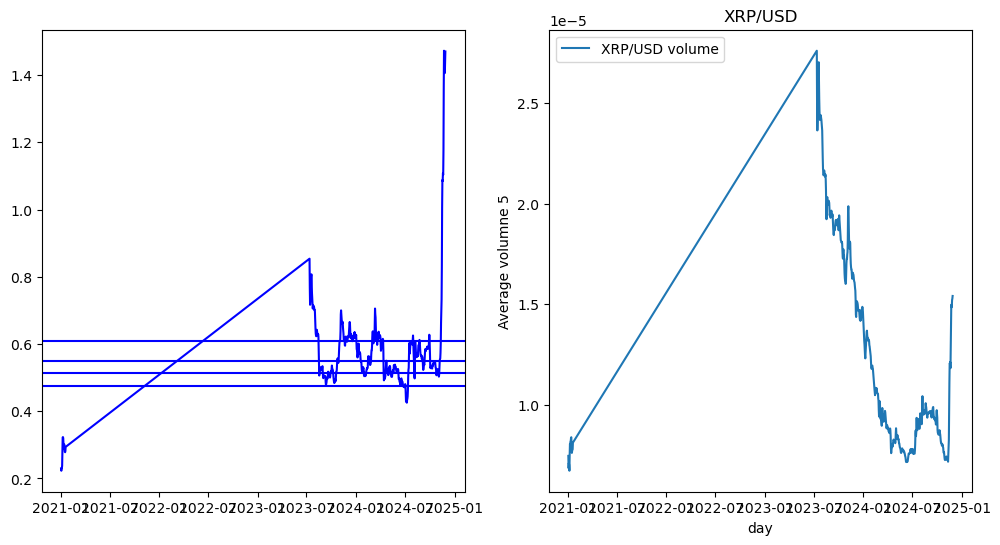

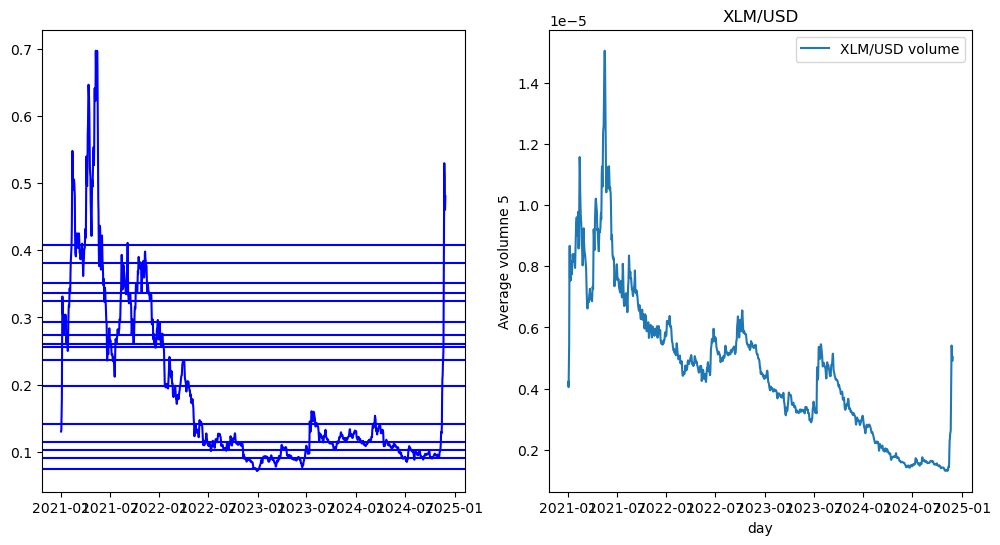

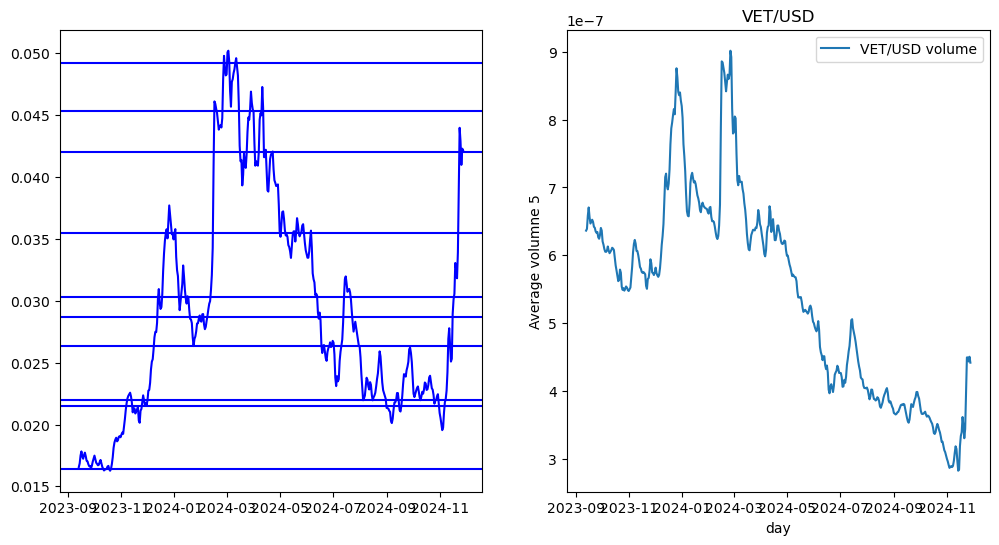

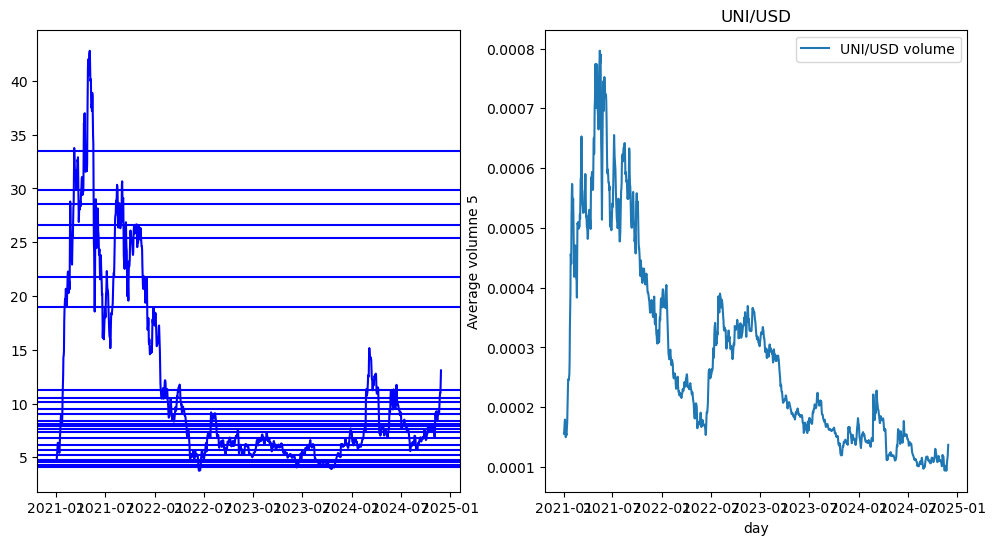

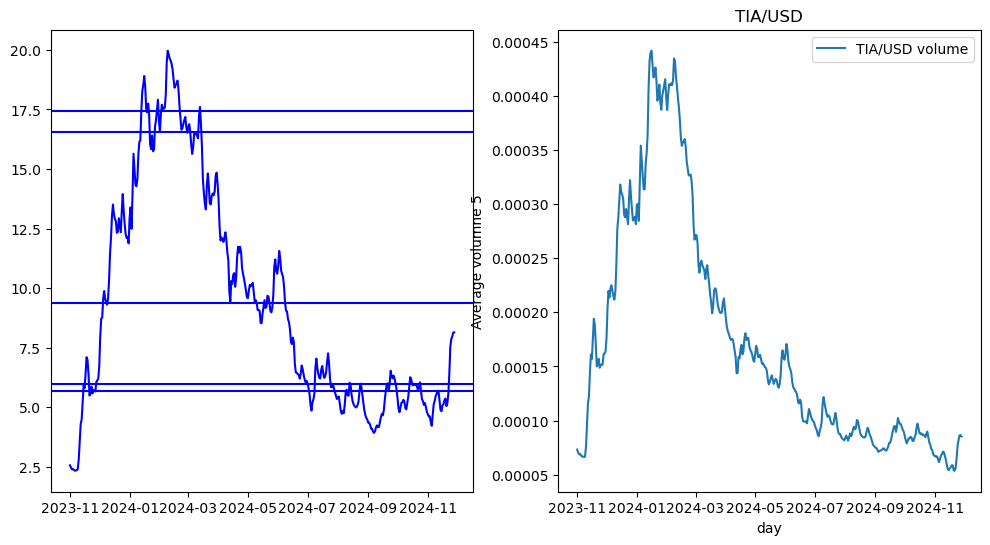

In [43]:
# Plot support levels
for cc in df_all_coins2['coin'].unique()[0:5]:
    df_coin = df_all_coins2[df_all_coins2['coin'] == cc]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(df_coin['day'], df_coin['price'], label=f'{cc} avg_price_5', color = 'blue')

    df_print_lines = df_coin.loc[df_coin['level'].notna(),['price_level', 'counter_level']].drop_duplicates().reset_index(drop = True)
    for i in range(df_print_lines.shape[0]):
        if df_print_lines.loc[i]['counter_level']>3:
            ax1.axhline(y=df_print_lines.loc[i]['price_level'], color='blue', linestyle='-')
        
    ax2.plot(df_coin['day'], df_coin['price_relative_to_btc'], label=f'{cc} volume')
    ax2.set_xlabel('day')
    ax2.set_ylabel('Average volumne 5')
    ax2.set_title(cc)
    ax2.legend()


# Machine Learning Teil

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Prepare data for ML model

In [25]:
df_all_coins2['relative_change_1d'] = df_all_coins2.sort_values('day', ascending = True).groupby('coin')['price'].pct_change(periods=1)*100
df_all_coins2['relative_change_3d'] = df_all_coins2.sort_values('day', ascending = True).groupby('coin')['price'].pct_change(periods=3)*100
df_all_coins2['relative_change_10d'] = df_all_coins2.sort_values('day', ascending = True).groupby('coin')['price'].pct_change(periods=10)*100
df_all_coins2['future_relative_change_1d'] = df_all_coins2.sort_values('day', ascending = False).groupby('coin')['price'].pct_change(periods=1)*100
df_all_coins2['future_relative_change_3d'] = df_all_coins2.sort_values('day', ascending = False).groupby('coin')['price'].pct_change(periods=3)*100
df_all_coins2['future_relative_change_5d'] = df_all_coins2.sort_values('day', ascending = False).groupby('coin')['price'].pct_change(periods=5)*100


In [ ]:
# Beste Entwicklung innerhalb von 15 Tagen - was kann ich erwarten, wenn ich einen Coin 15 Tage beobachte
df_all_coins2.sort_values(by = ['coin', 'day'], ascending = False, inplace = True)
df_all_coins2['target_15_d'] = df_all_coins2.groupby('coin')['price'].shift(1).transform(lambda d: d.rolling(window=15, min_periods=15, center=False).max())
df_all_coins2['target_15_d'] = (df_all_coins2['target_15_d'] / df_all_coins2['price'] - 1)*100    

In [ ]:
'''
features = ['weekday'] + ['price_level_below', 'price_level_above', 'delta_to level_below', 'delta_to level_above', 'momentum',
                          'relative_change_1d','relative_change_3d']'''
features = ['delta_to level_below', 'delta_to level_above',
       'delta_to level_below2', 'delta_to level_above2','delta_to level_below3', 'delta_to level_above3', 'momentum_price',
       'momentum_price_5', 'momentum_volume', 'momentum_volume_5','momentum_volume', 'momentum_volume_usd_5',
       'relative_change_1d', 'relative_change_3d', 'relative_change_10d']
target = 'target_15_d'

# Prepare the features and target
df_test = df_all_coins2.loc[(df_all_coins2['day'] >= day_apply) & (df_all_coins2['day'] <= str(today - timedelta(days=14)))]
df_model = df_all_coins2.loc[(df_all_coins2['day'] < day_apply)].dropna(subset=features +[target])
df_application = df_all_coins2.loc[(df_all_coins2['day'] == str(today))].dropna(subset=features)

Train and evaluate RF-regressor

In [28]:
def train_test_plot_rf(df_in, coin_sel, feat, targ, test_size_in):
        
    df_coin = df_in.loc[df_in.coin == coin_sel]     
    X = df_coin[feat]
    y = df_coin[targ]

    #X = X.fillna(0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Random Forest Regressor
    model = RandomForestRegressor(n_estimators=25, max_depth=3, criterion='absolute_error', random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate the model
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print(coin_sel)
    print(f'Train MAE: {train_mae}')
    print(f'Test MAE: {test_mae}')

    # Add predictions to the DataFrame for plotting
    df_test = X_test.copy()
    df_test['actual'] = y_test
    df_test['predicted'] = y_pred_test
    df_test['coin'] = coin_sel
    return model, df_test

In [29]:
# Initialize a dictionary to store models for each coin
models = {}
df_results = pd.DataFrame()
for coin_sel in df_model.coin.unique():
    model_i, df_res_i = train_test_plot_rf(df_in = df_model, coin_sel = coin_sel, feat = features, targ = target, test_size_in = 0.2)
    df_results = pd.concat([df_results, df_res_i])
    models[coin_sel] = model_i

XRP/USD
Train MAE: 4.597086994536088
Test MAE: 4.602731025706776
XLM/USD
Train MAE: 7.476731803785851
Test MAE: 8.035489396251817
VET/USD
Train MAE: 7.975570410212106
Test MAE: 9.821378399310802
UNI/USD
Train MAE: 10.11497170733534
Test MAE: 10.185242447249722
TIA/USD
Train MAE: 11.192640315886543
Test MAE: 13.236188064262027
SUI/USD
Train MAE: 10.524461140532615
Test MAE: 13.126141431069126
SOL/USD
Train MAE: 12.736906758617458
Test MAE: 13.699217669469531
SEI/USD
Train MAE: 13.886957389003022
Test MAE: 17.25322990431442
SD/USD
Train MAE: 0.9663165808725236
Test MAE: 2.551900341578888
SAND/USD
Train MAE: 7.504836538441924
Test MAE: 8.777524315065916
QNT/USD
Train MAE: 9.980274140243996
Test MAE: 9.15099153344257
OP/USD
Train MAE: 12.905674136362022
Test MAE: 18.21893300128707
NEAR/USD
Train MAE: 10.785222578952878
Test MAE: 12.96659058627269
MKR/USD
Train MAE: 9.553591331663993
Test MAE: 10.404490601086259
MATIC/USD
Train MAE: 11.235868252751276
Test MAE: 12.090163752846394
MATH/USD
T

In [30]:
# Calculate predictions for today
df_test = df_test.fillna(0)
df_test['actual'] = df_test[target]
df_test.loc[:, 'predicted'] = np.nan
# Get predictions from each model
for coin_i, model_i in models.items():
    X_test = df_test.loc[df_test.coin == coin_i, features]
    df_test.loc[df_test.coin == coin_i, 'predicted'] = model_i.predict(X_test)
df_test = df_test.loc[df_test[target] != 0]

In [31]:
# get real predictions by replacing prediction with test outcomes
# Create bins for predicted values
bins = [-np.inf, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6,7,8,9,10, np.inf]
labels = ['<-5', '-5 to -4', '-4 to -3', '-3 to -2', '-2 to -1', '-1 to 0', '0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5', 
          '5 to 6','6 to 7', '7 to 8', '8 to 9', '9 to 10', '>10']
df_results['pred_bins'] = pd.cut(df_results['predicted'], bins=bins, labels=labels)
df_results['pred_bins'] = df_results['pred_bins'].astype(str)
df_test['pred_bins'] = pd.cut(df_test['predicted'], bins=bins, labels=labels)
df_test['pred_bins'] = df_test['pred_bins'].astype(str)

# Calculate average actual values per prediction bin
average_actual_per_bin = df_results.groupby(['coin', 'pred_bins'])['actual'].agg(['mean']).reset_index().rename(columns={'mean': 'prediction_real'})
df_test = df_test.merge(average_actual_per_bin, on=['coin', 'pred_bins'], how='left')
df_test['prediction_real'].fillna(0, inplace=True)

Evaluate strategy

In [32]:
df_test.loc[df_test['prediction_real'].apply(lambda x: abs(x) > 8),['coin', 'day',  'prediction_real', target]].sort_values('prediction_real', ascending = False)

coin        day  prediction_real  target_15_d
3      XRP/USD 2024-11-10       114.848492   156.452456
1322  BONK/USD 2024-10-12        68.115564    10.187110
1321  BONK/USD 2024-10-13        68.115564    11.474644
1308  BONK/USD 2024-10-26        68.115564    15.020428
1176   DNT/USD 2024-10-29        52.055372     5.913272
...        ...        ...              ...          ...
1701  AAVE/USD 2024-10-20         8.081880    -1.583346
1700  AAVE/USD 2024-10-21         8.081880    -1.442169
1697  AAVE/USD 2024-10-24         8.081880    23.167076
469    QNT/USD 2024-10-04         8.023109     0.562892
459    QNT/USD 2024-10-14         8.023109     1.722063

[1134 rows x 4 columns]

Modelle zeigen nachfolgend, dass einige Coins stärker Momentum getrieben sind und andere sich eher in bestimmten Intervallen bewegen

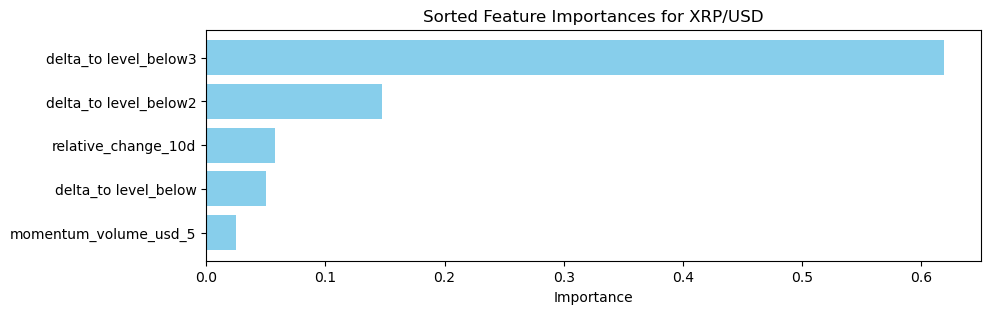

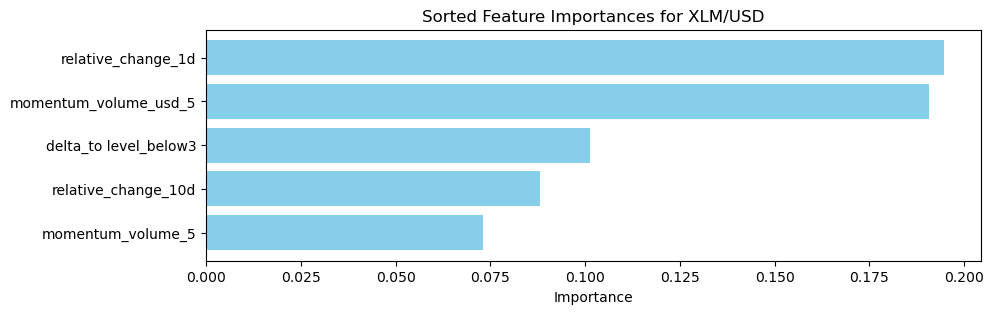

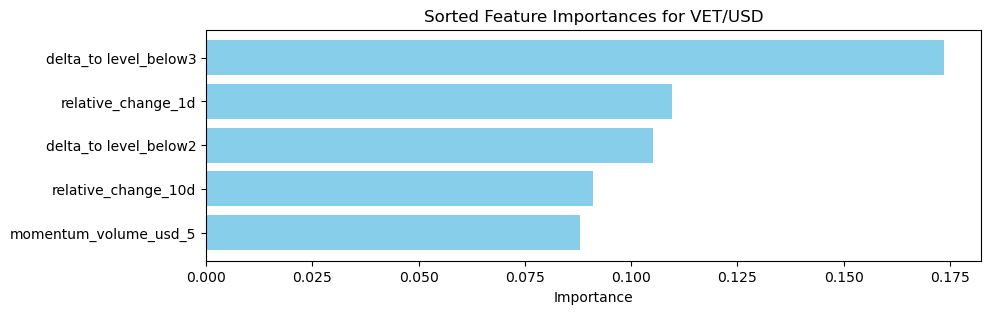

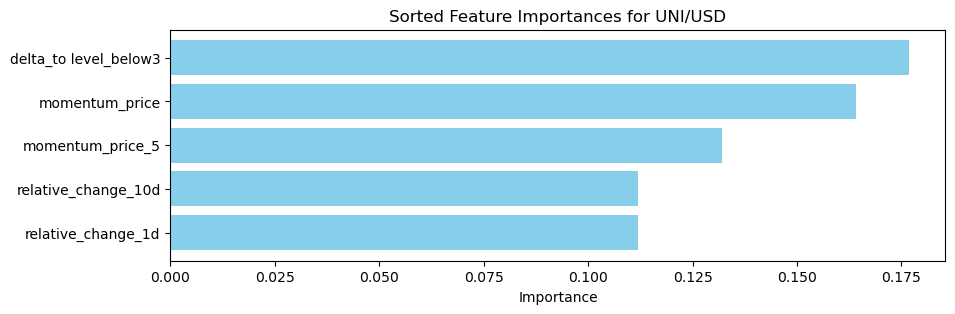

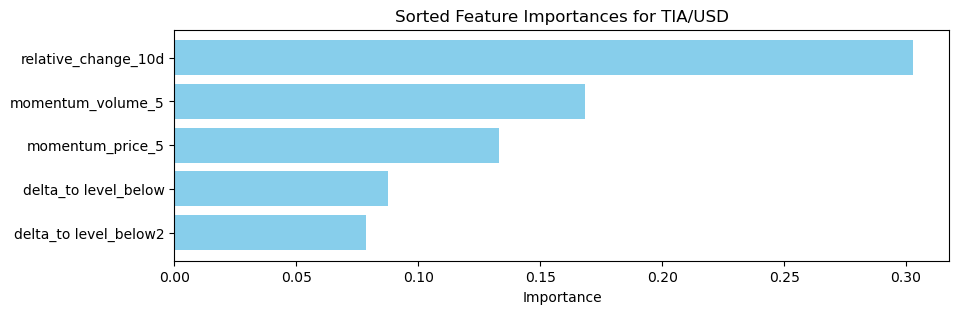

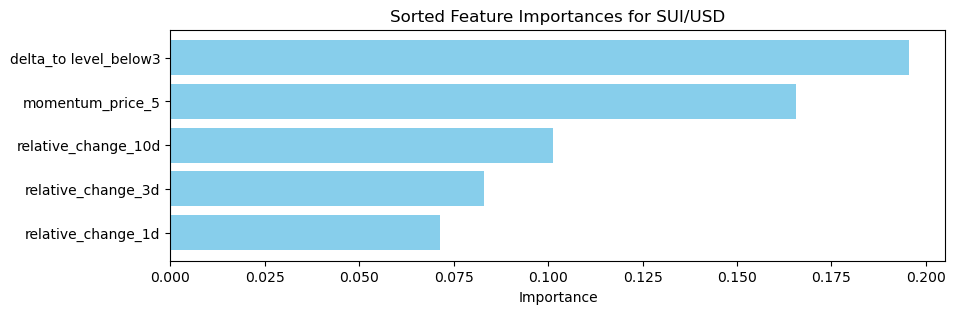

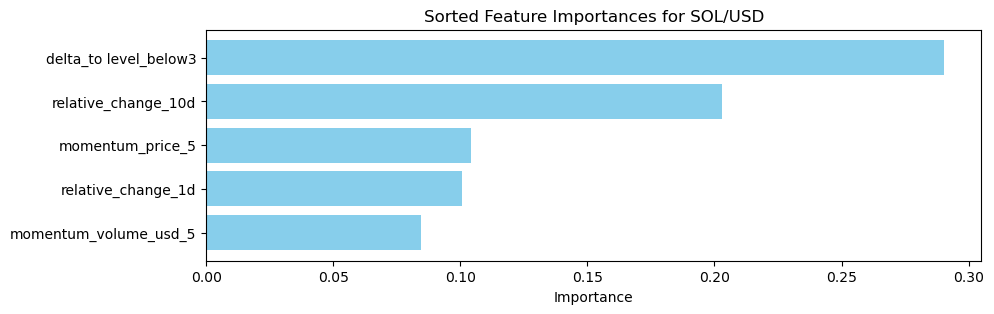

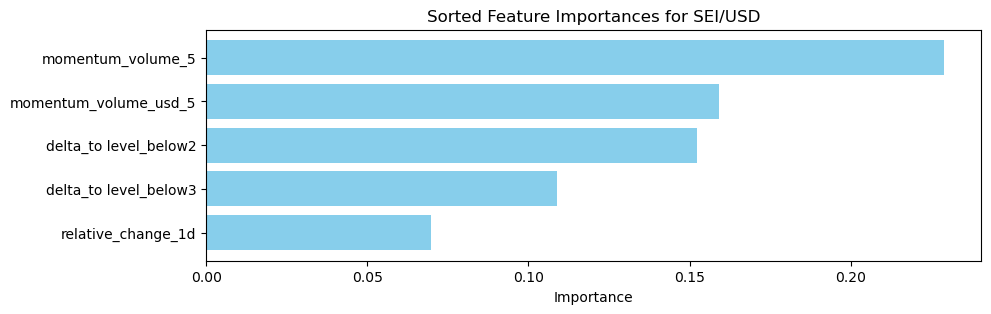

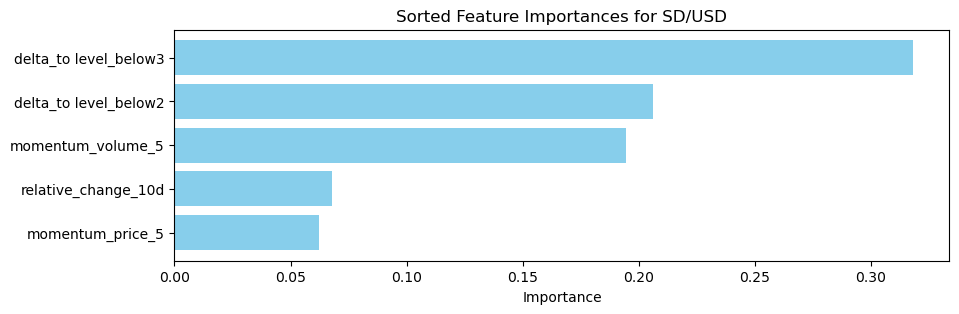

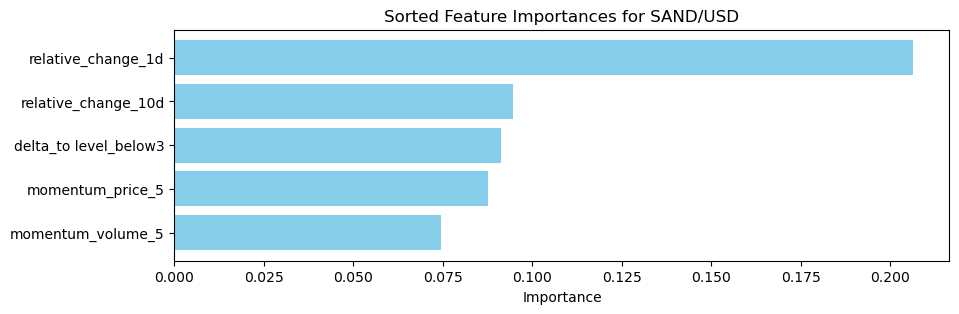

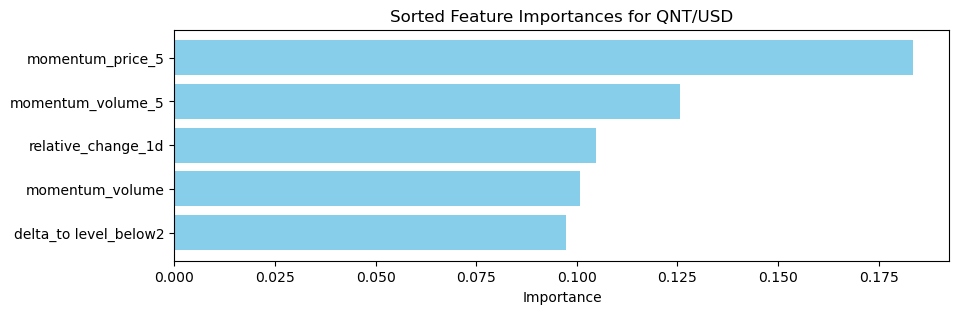

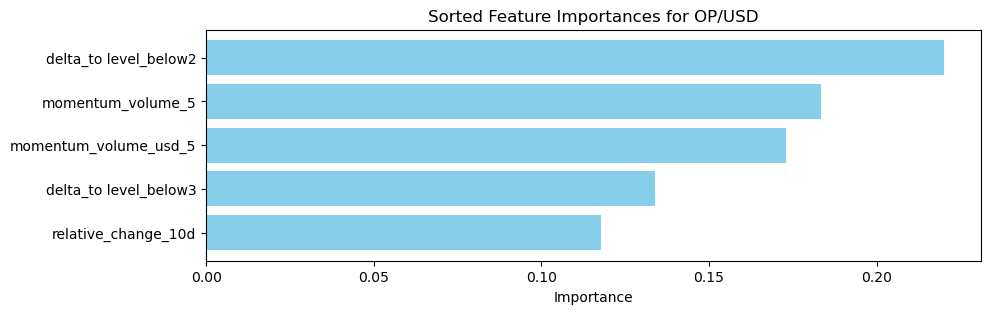

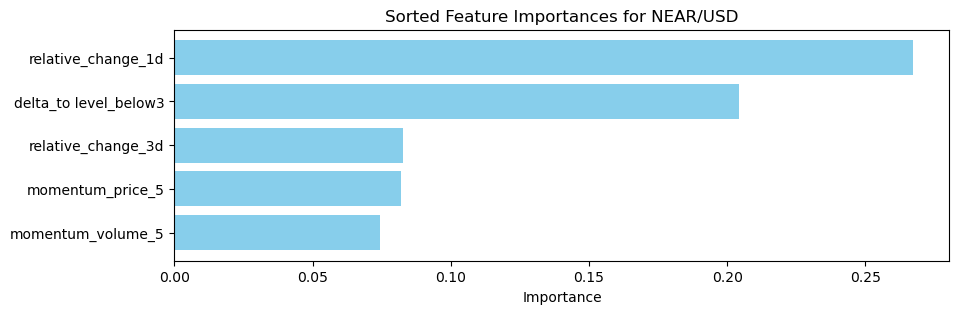

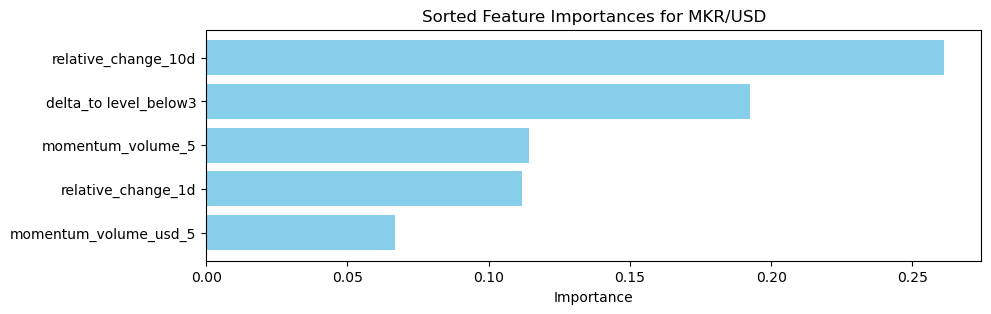

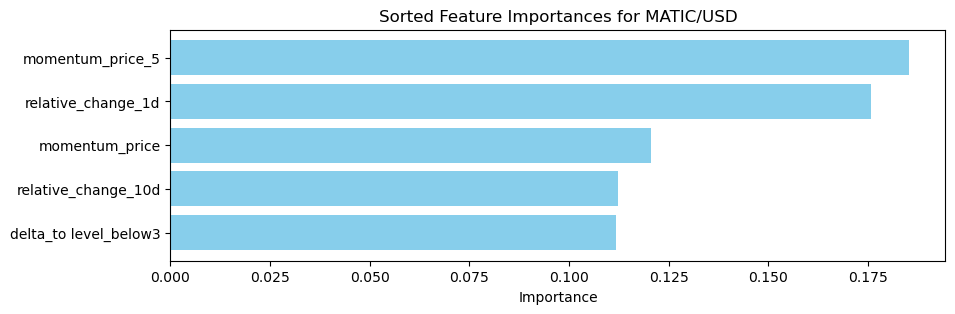

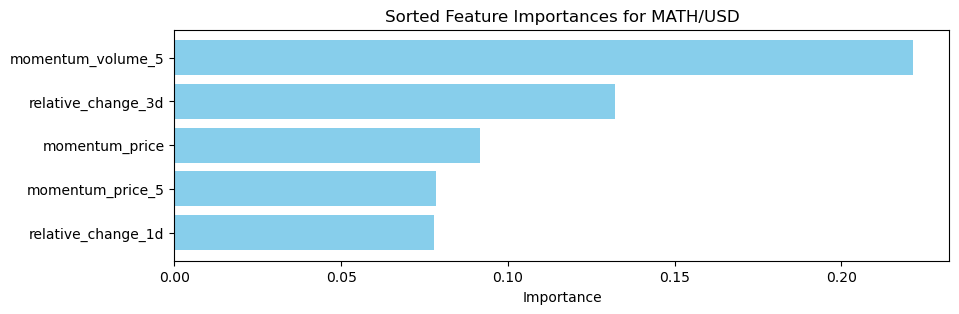

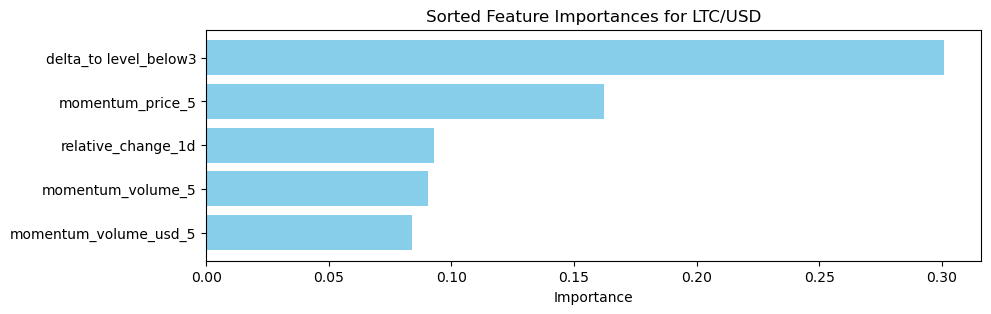

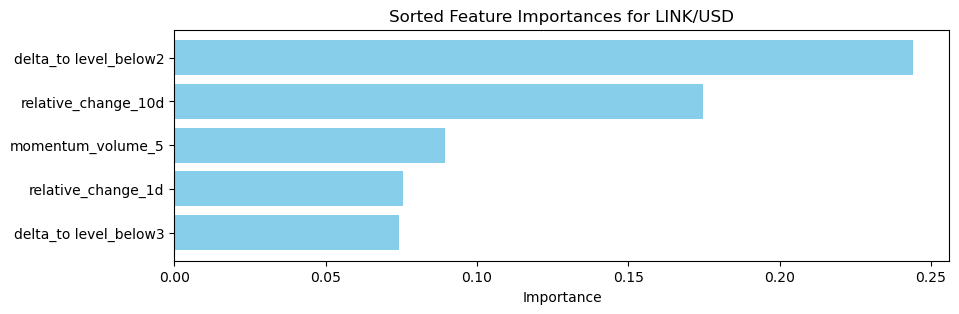

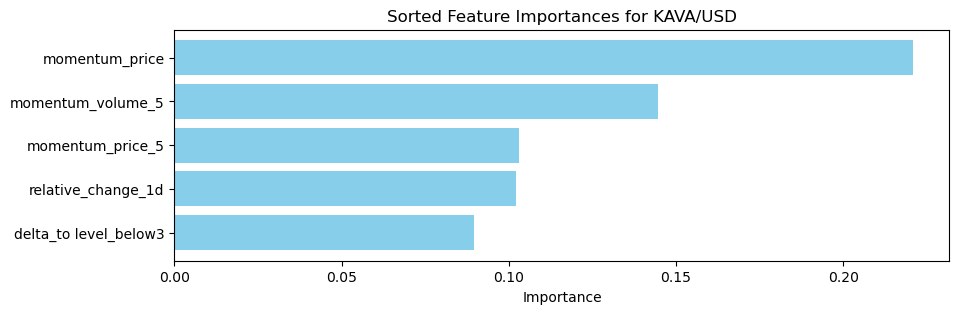

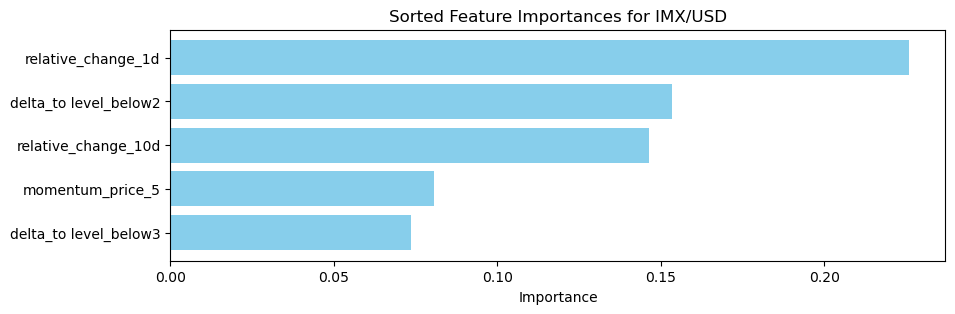

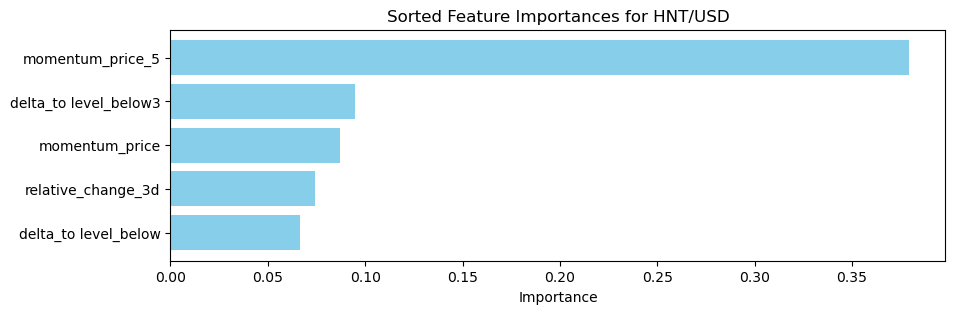

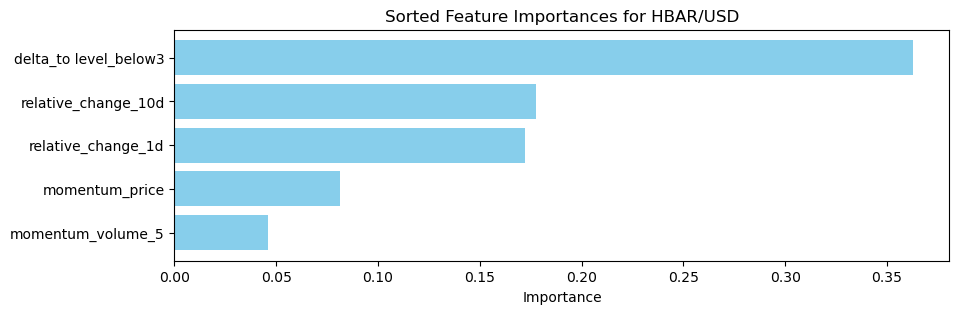

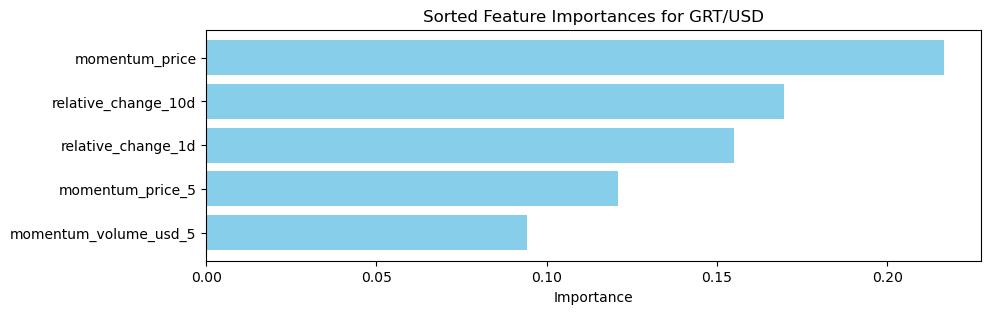

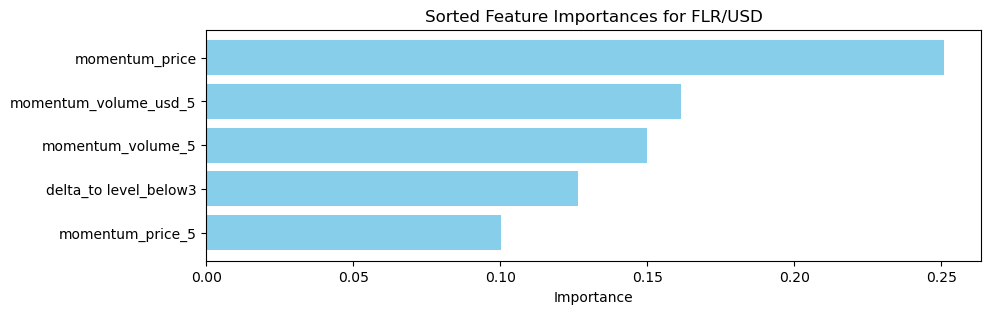

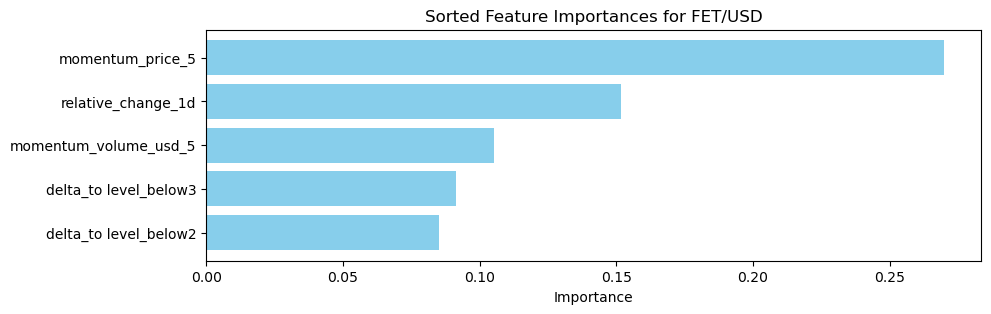

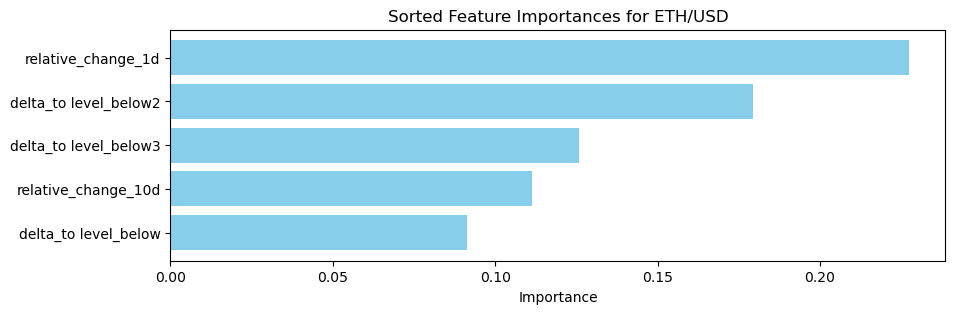

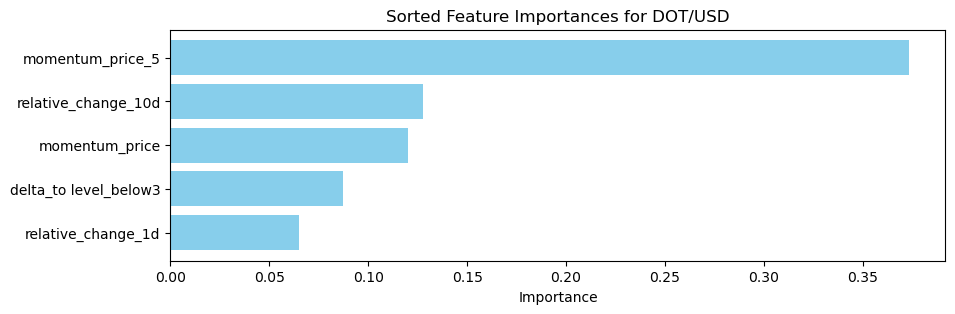

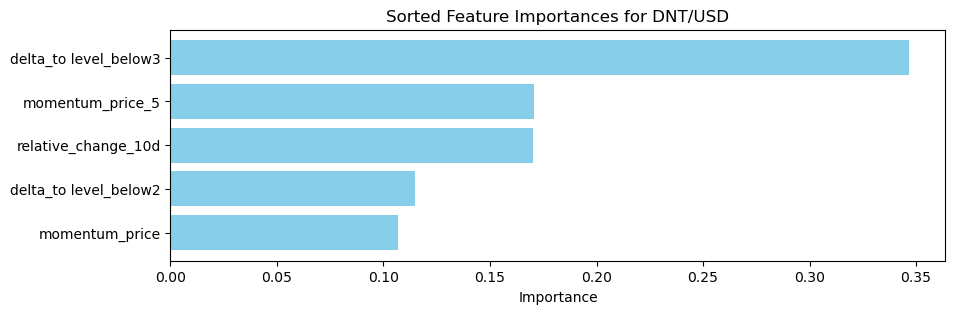

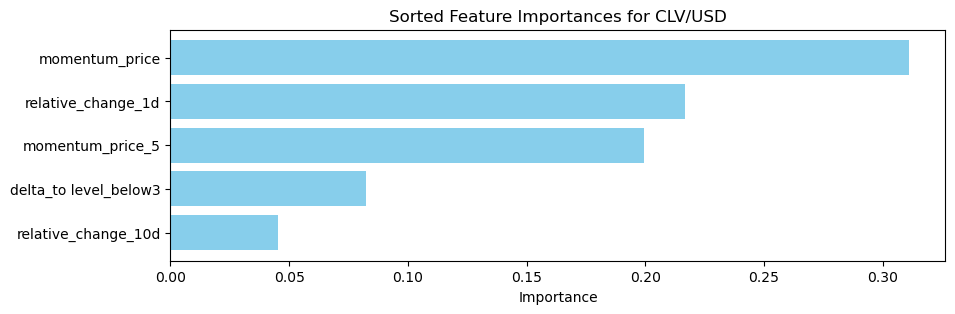

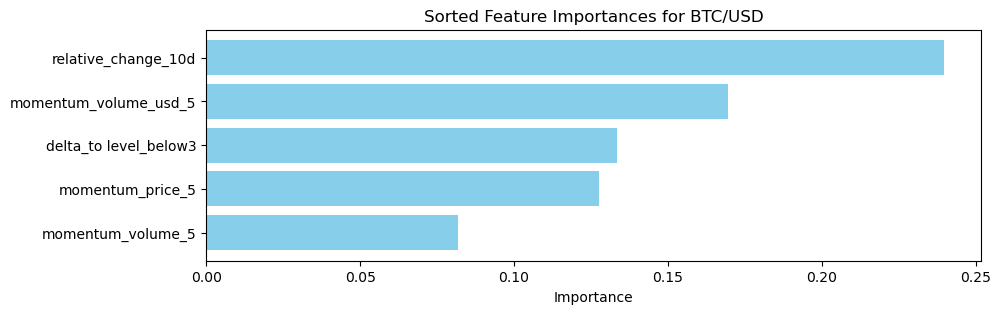

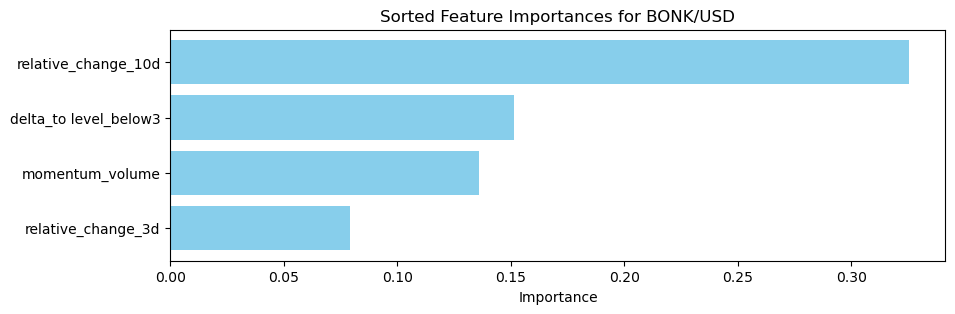

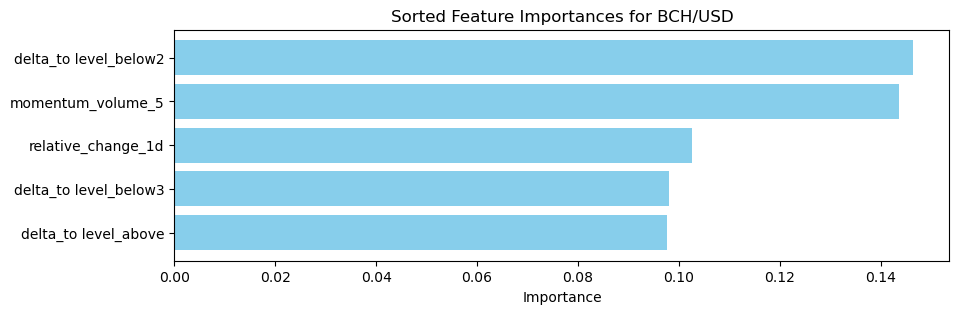

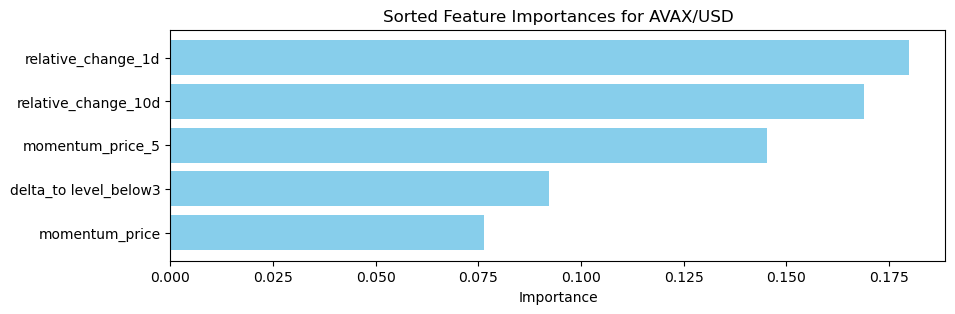

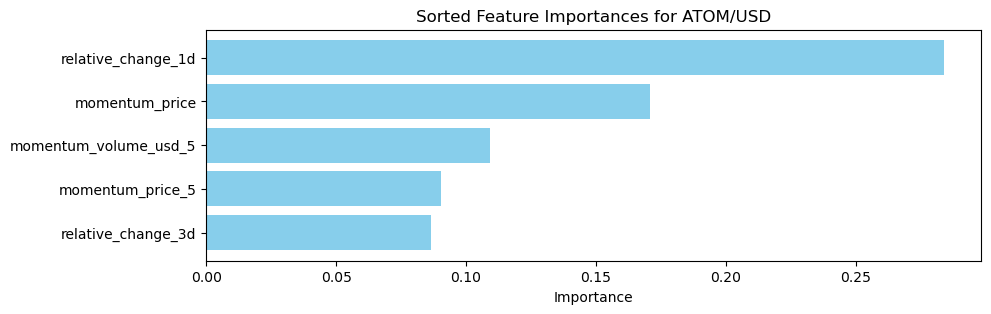

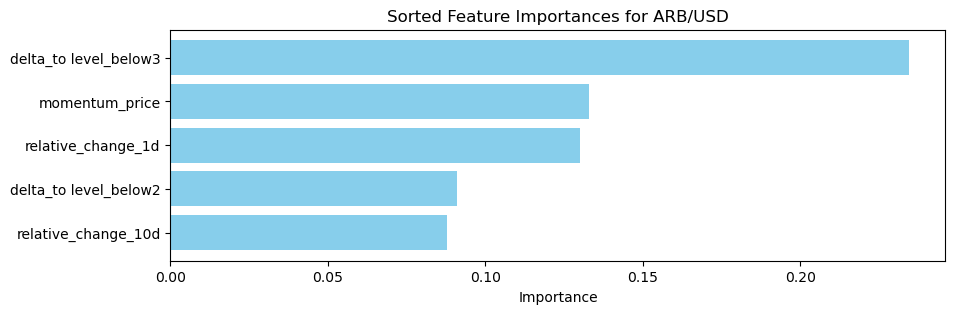

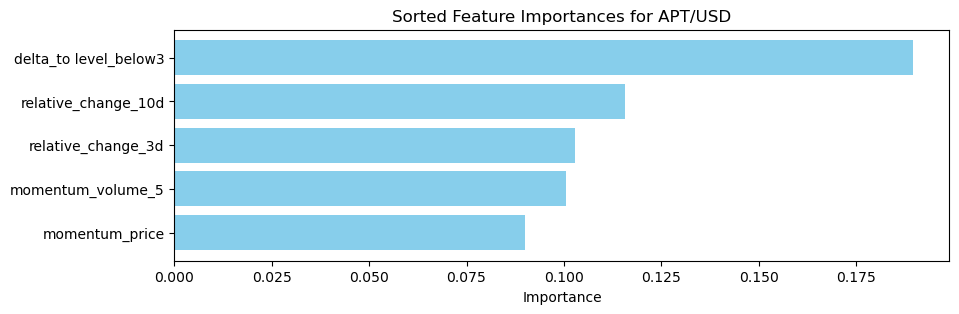

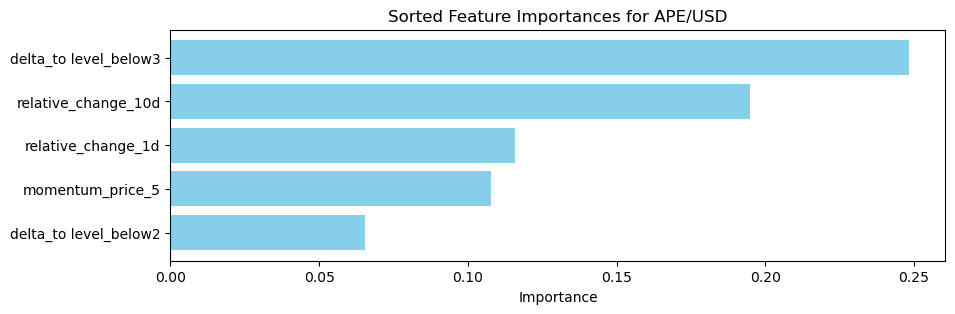

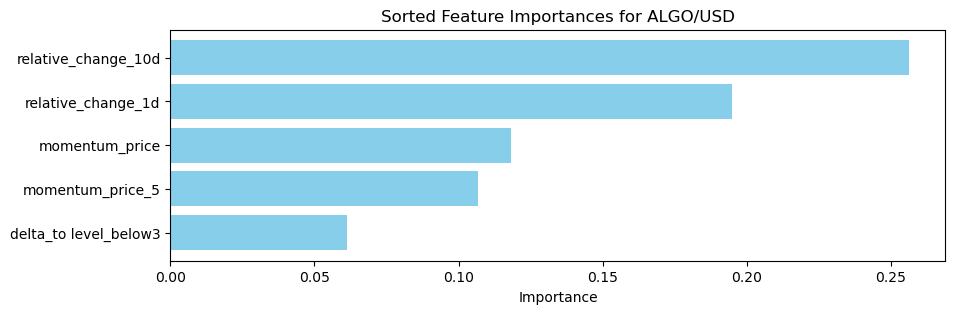

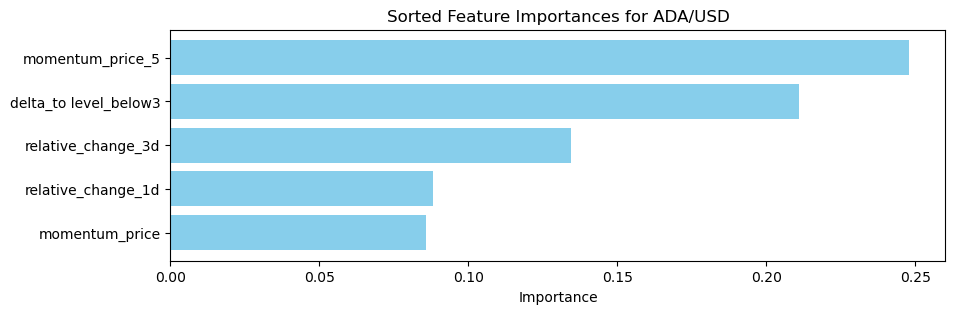

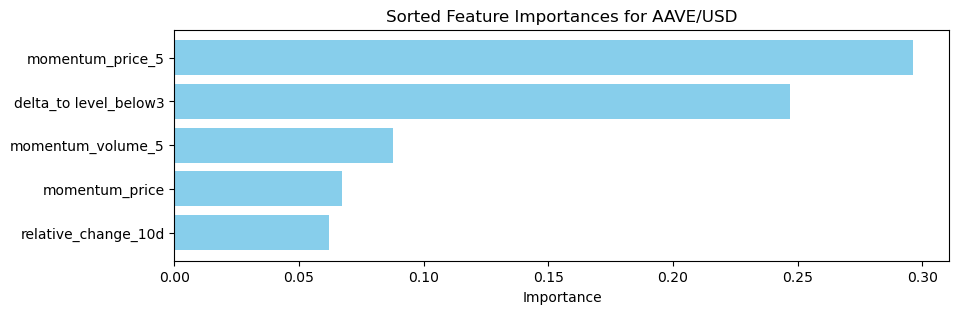

In [34]:
def plot_feature_importances(models, features):
    sorted_feature_importances = {}
    for coin, model in models.items():
        importances = model.feature_importances_
        sorted_indices = importances.argsort()[::-1]
        sorted_feature_importances[coin] = [(features[i], importances[i]) for i in sorted_indices[0:5]]

    for coin, importances in sorted_feature_importances.items():
        features, scores = zip(*importances)

        plt.figure(figsize=(10, 3))
        plt.barh(features, scores, color='skyblue')
        plt.xlabel('Importance')
        plt.title(f'Sorted Feature Importances for {coin}')
        plt.gca().invert_yaxis()  # To display the highest importance feature at the top
        plt.show()

# Apply the function to all models
plot_feature_importances(models, X_test.columns)

In [35]:
# Create bins for predicted values
bins = [-np.inf, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6,7,8,9,10, np.inf]
labels = ['<-5', '-5 to -4', '-4 to -3', '-3 to -2', '-2 to -1', '-1 to 0', '0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5', 
          '5 to 6','6 to 7', '7 to 8', '8 to 9', '9 to 10', '>10']
df_results['pred_bins'] = pd.cut(df_results['predicted'], bins=bins, labels=labels)

# Calculate average actual values per prediction bin
average_actual_per_bin = df_results.groupby(['coin', 'pred_bins'])['actual'].agg(['count','min', 'max', 'median', 'mean']).reset_index()
for c in average_actual_per_bin['coin'].unique():
    print(c)
    print(average_actual_per_bin.loc[average_actual_per_bin['coin'] == c])

AAVE/USD
        coin pred_bins  count        min         max     median       mean
0   AAVE/USD       <-5      0        NaN         NaN        NaN        NaN
1   AAVE/USD  -5 to -4      0        NaN         NaN        NaN        NaN
2   AAVE/USD  -4 to -3      0        NaN         NaN        NaN        NaN
3   AAVE/USD  -3 to -2      0        NaN         NaN        NaN        NaN
4   AAVE/USD  -2 to -1      0        NaN         NaN        NaN        NaN
5   AAVE/USD   -1 to 0      0        NaN         NaN        NaN        NaN
6   AAVE/USD    0 to 1      0        NaN         NaN        NaN        NaN
7   AAVE/USD    1 to 2      0        NaN         NaN        NaN        NaN
8   AAVE/USD    2 to 3      0        NaN         NaN        NaN        NaN
9   AAVE/USD    3 to 4      0        NaN         NaN        NaN        NaN
10  AAVE/USD    4 to 5      4  -1.556658   17.822861   5.941177   7.037139
11  AAVE/USD    5 to 6      9  -5.513695   44.981912   5.163379   8.081880
12  AAVE/USD    

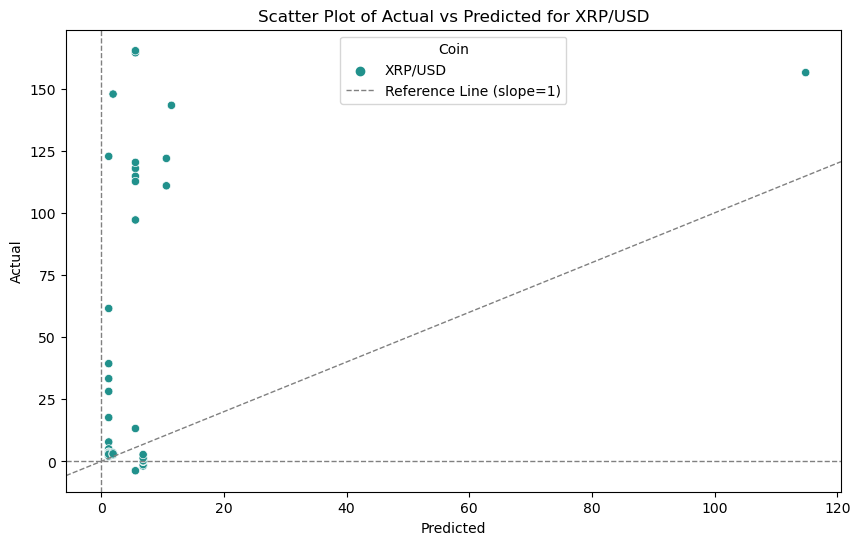

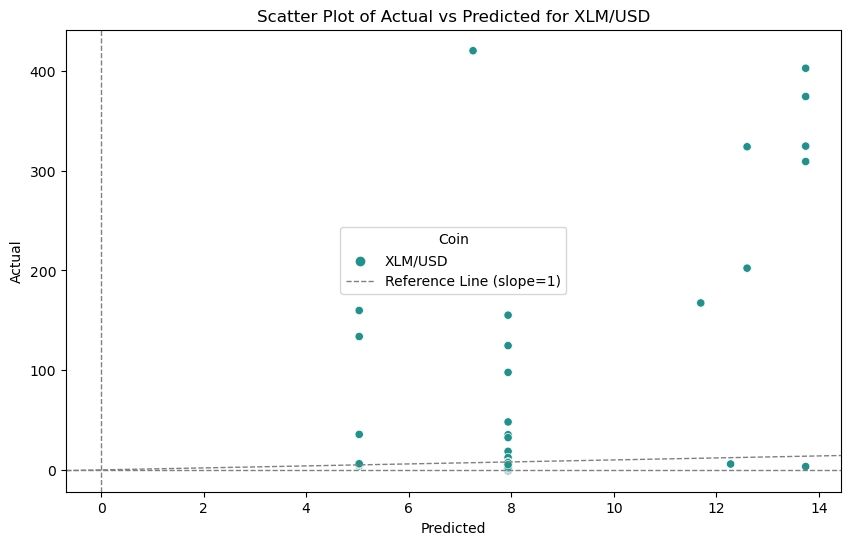

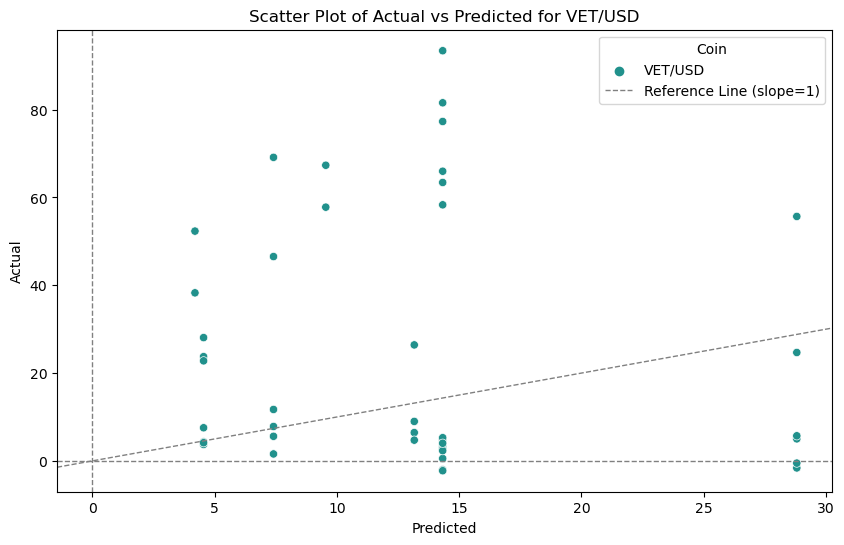

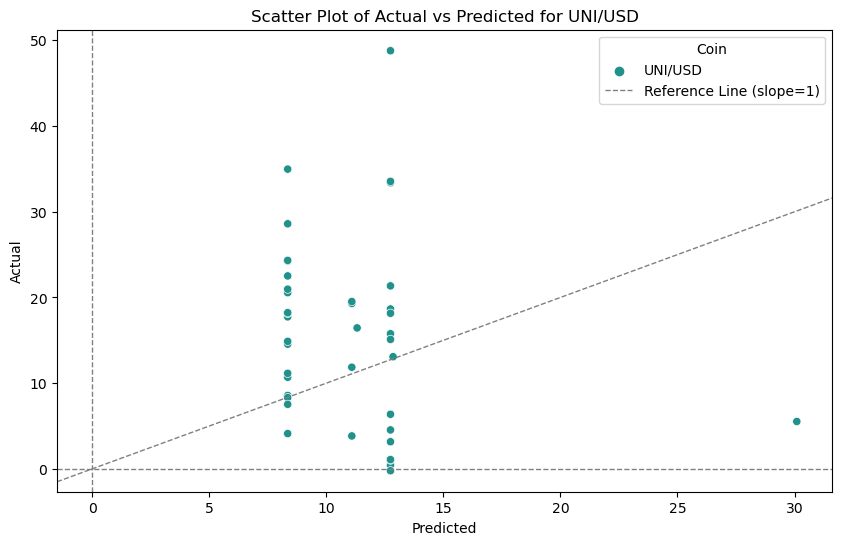

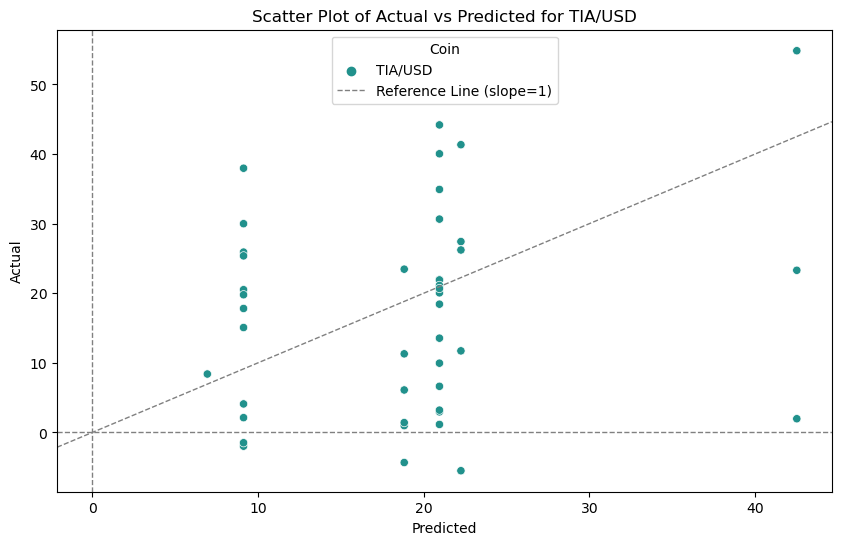

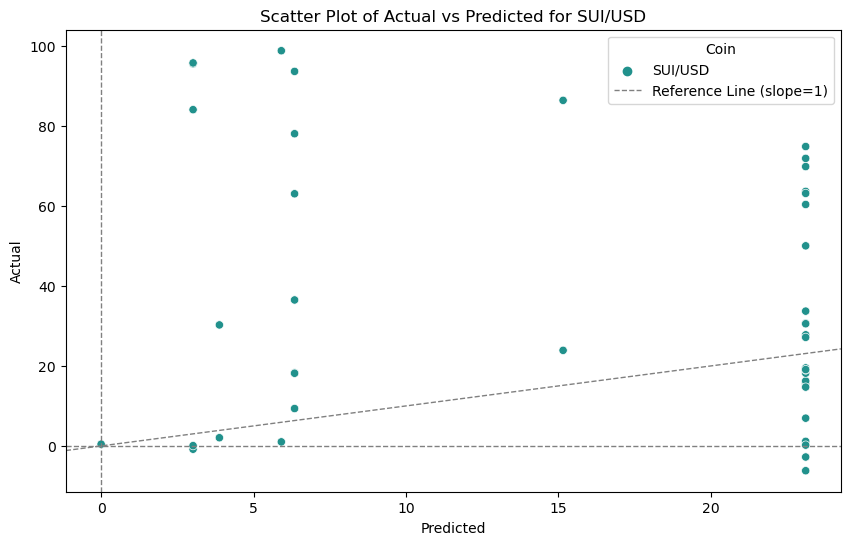

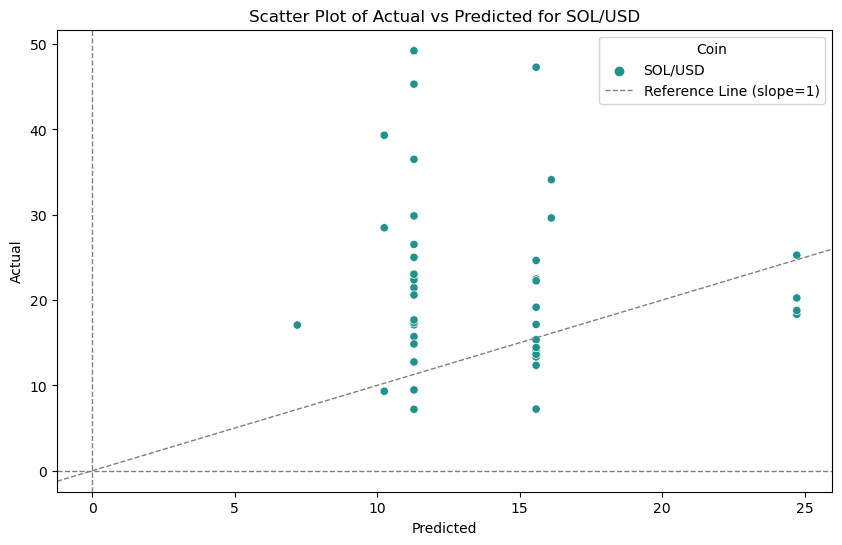

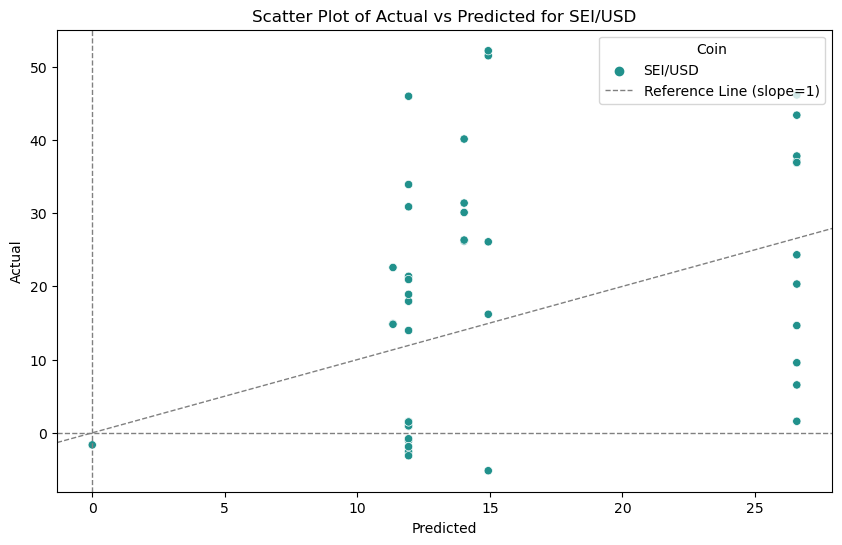

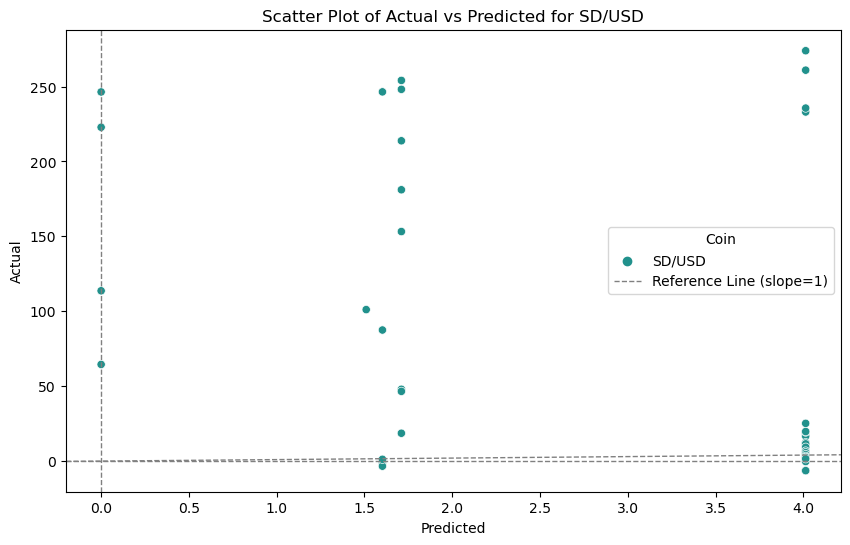

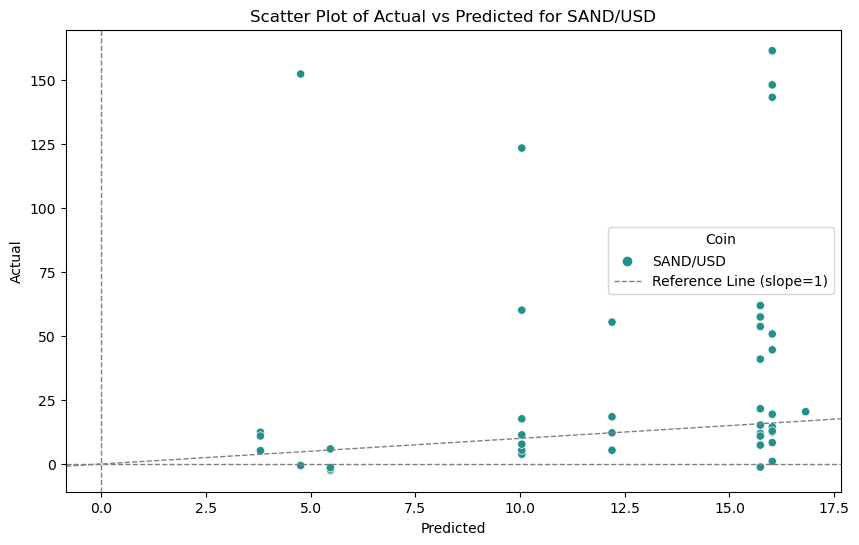

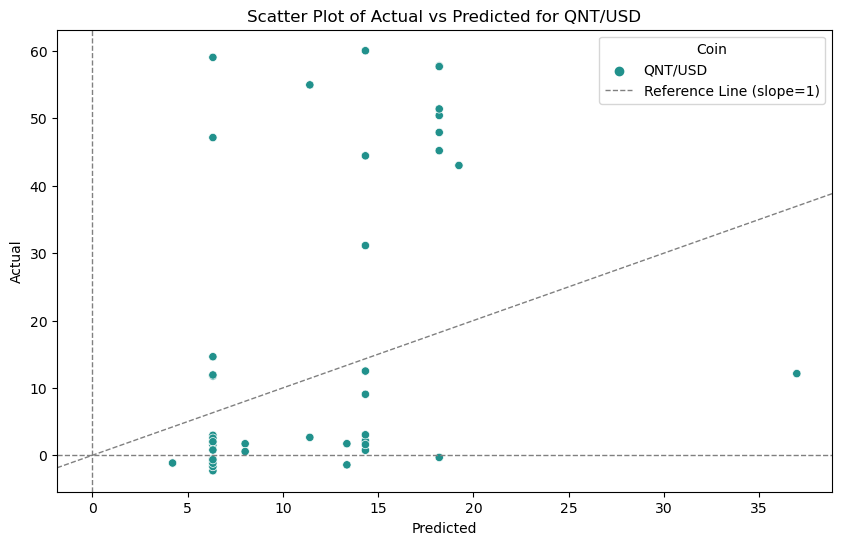

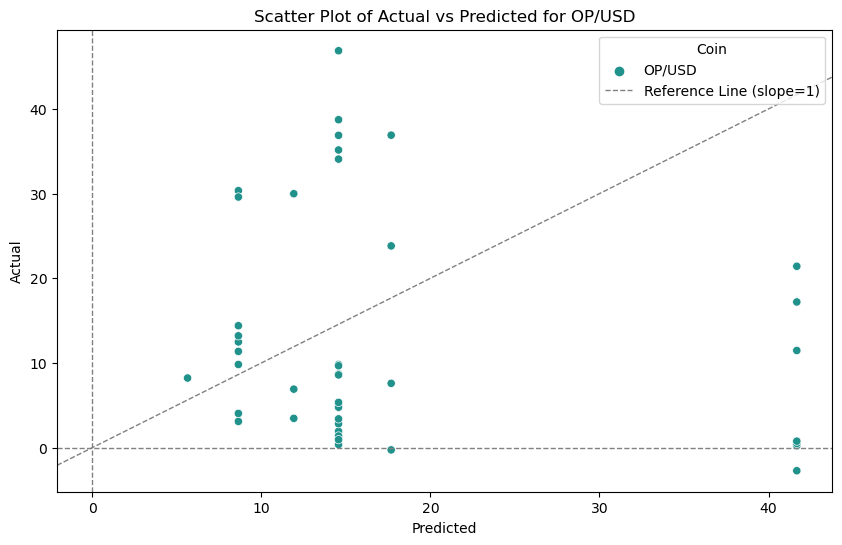

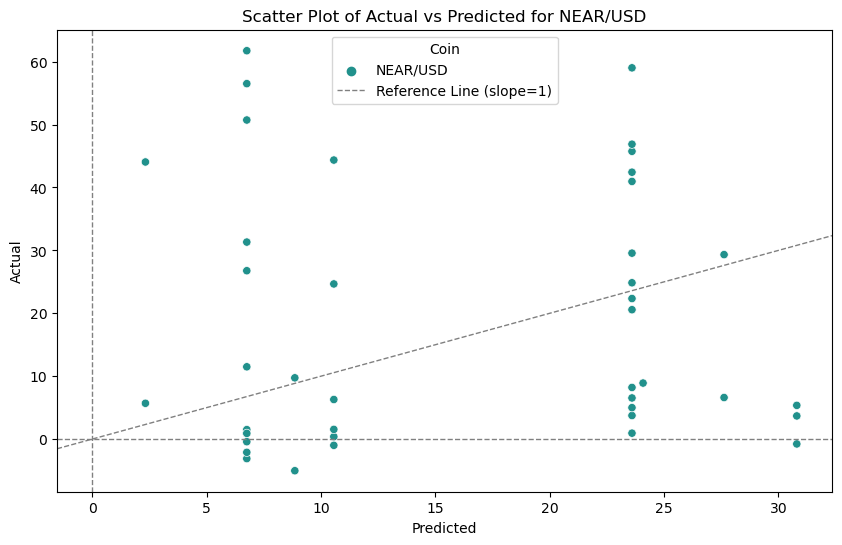

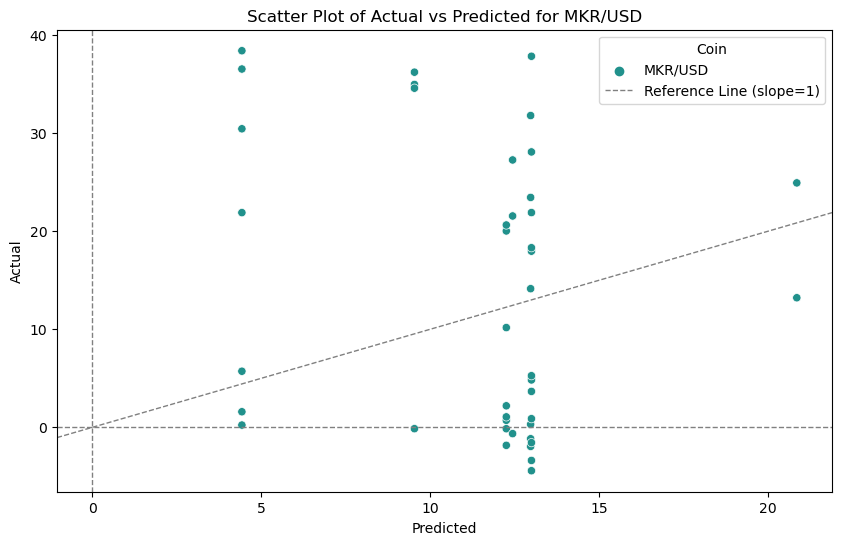

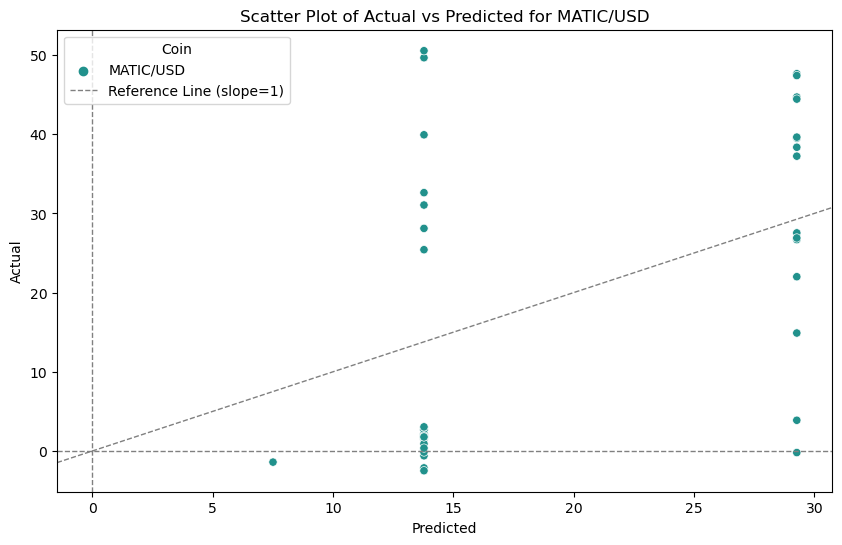

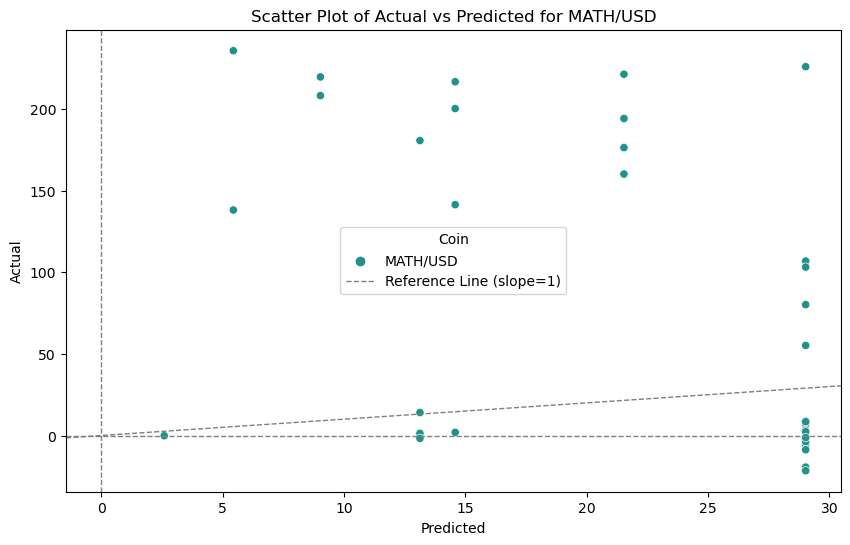

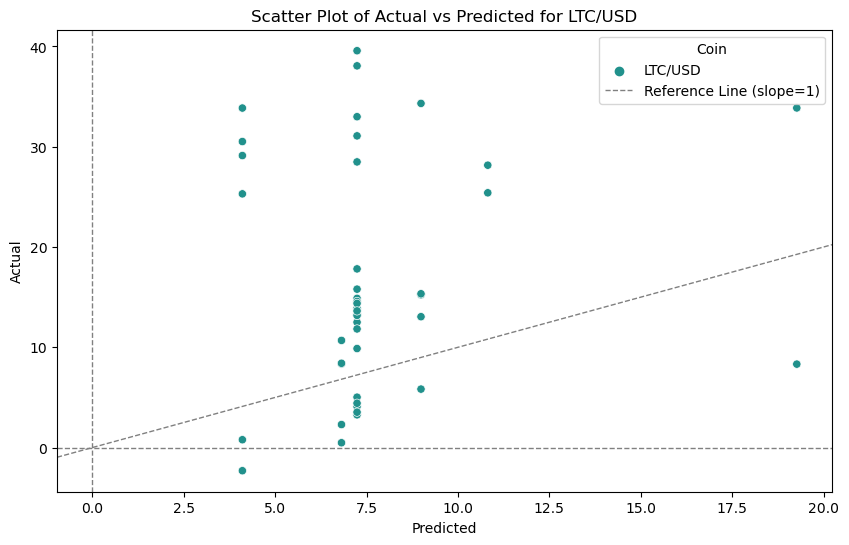

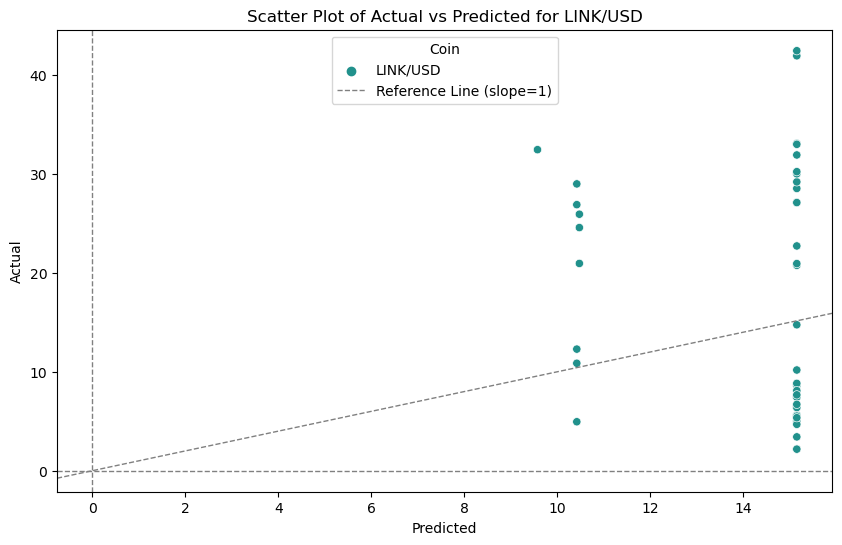

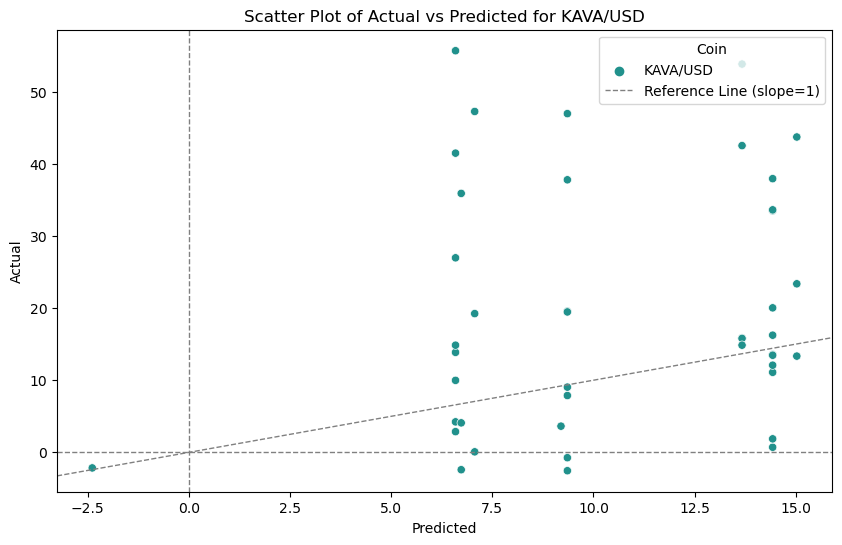

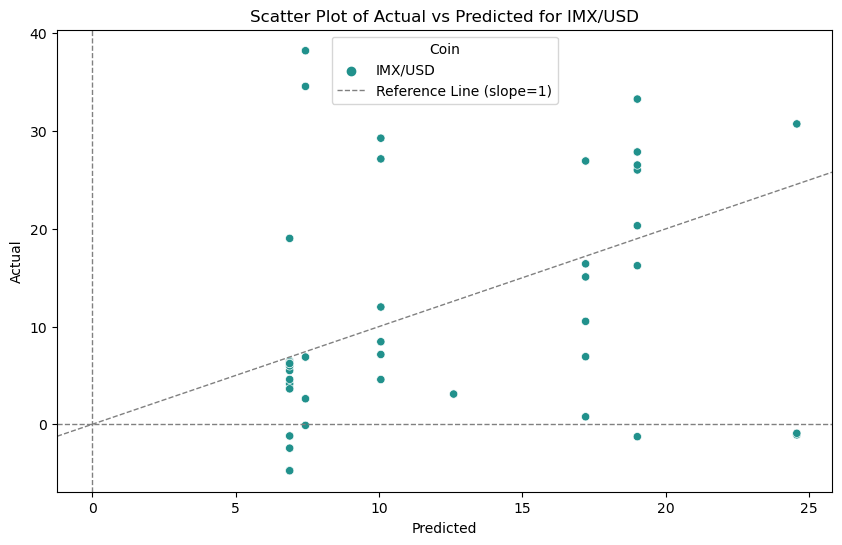

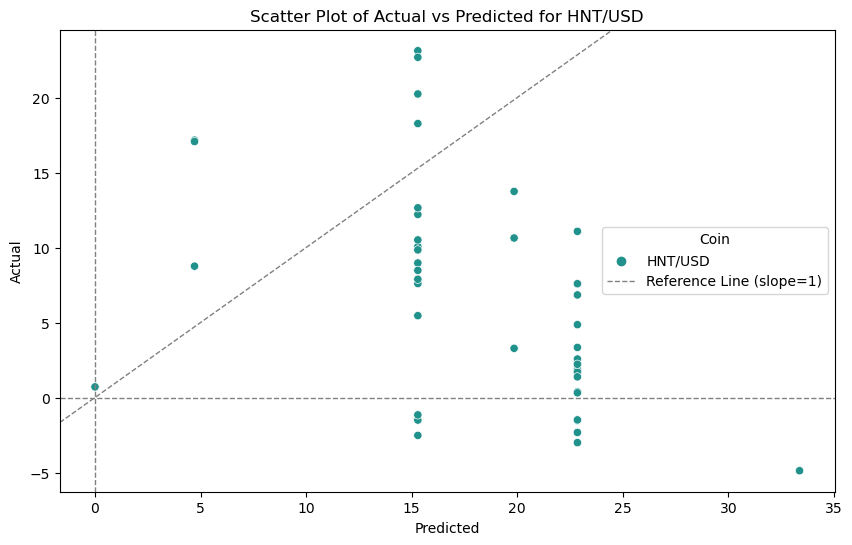

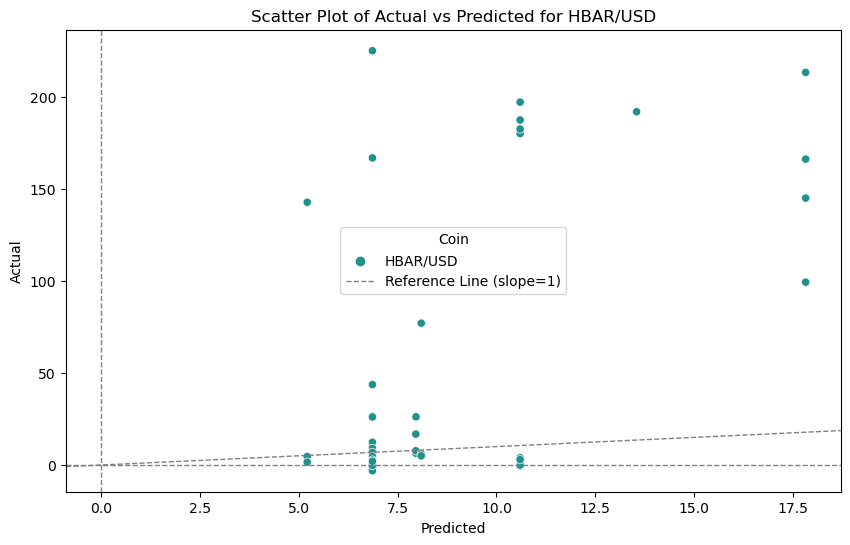

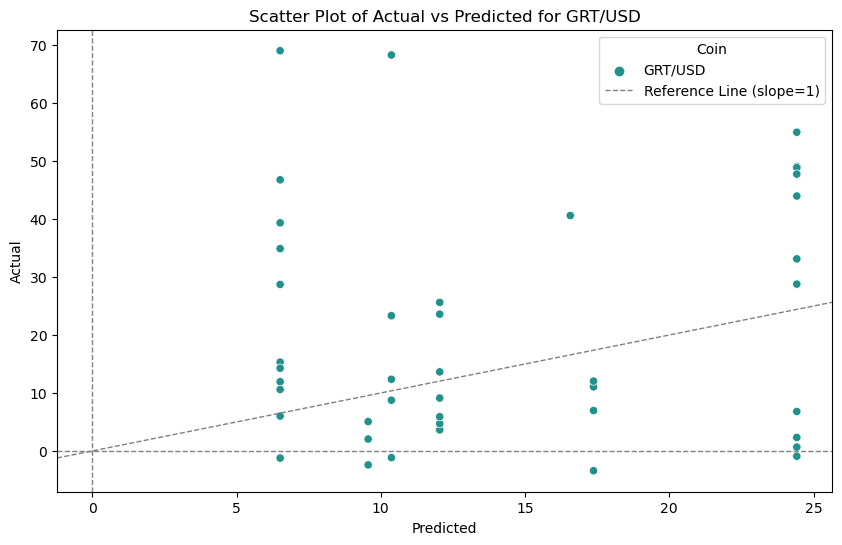

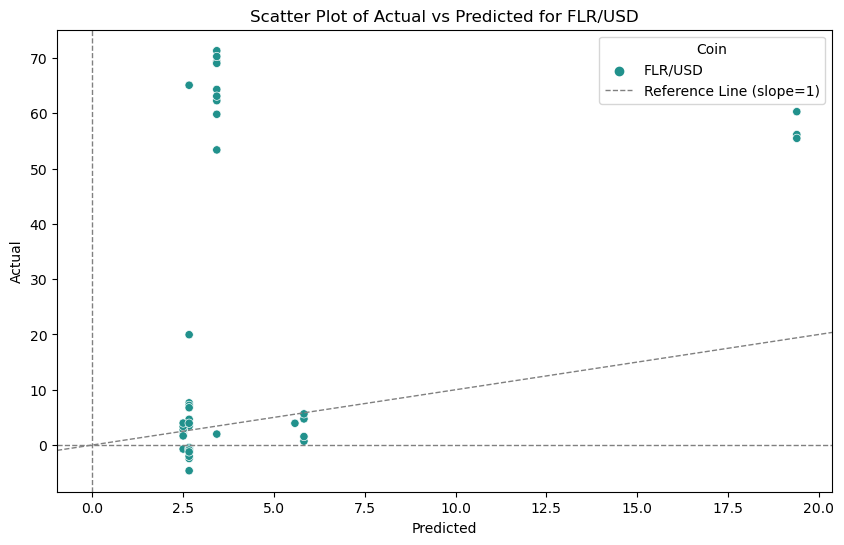

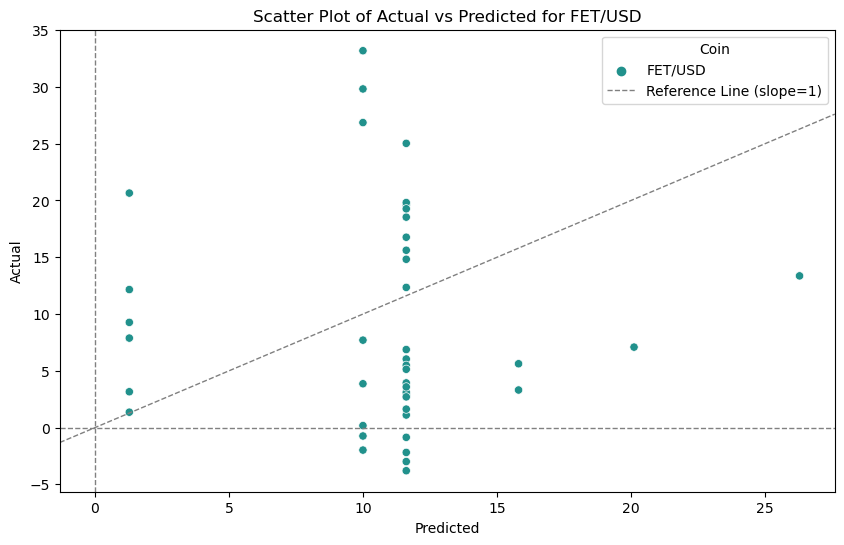

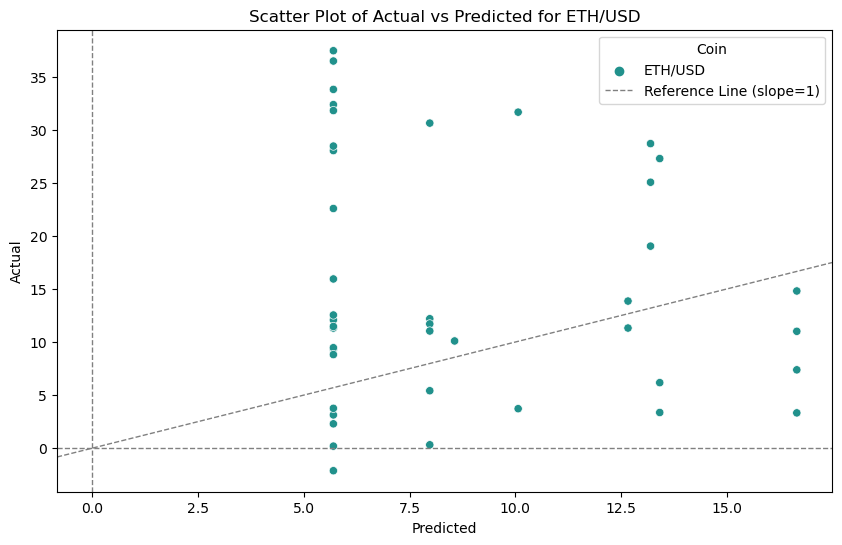

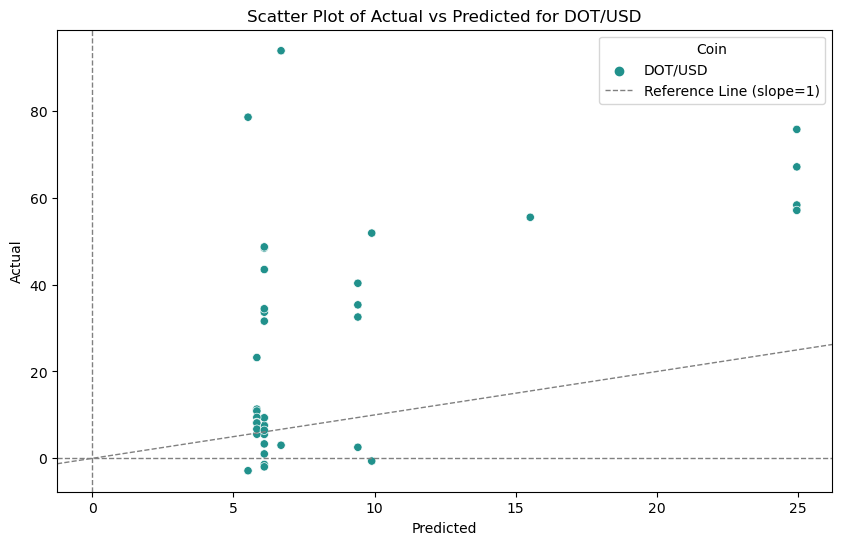

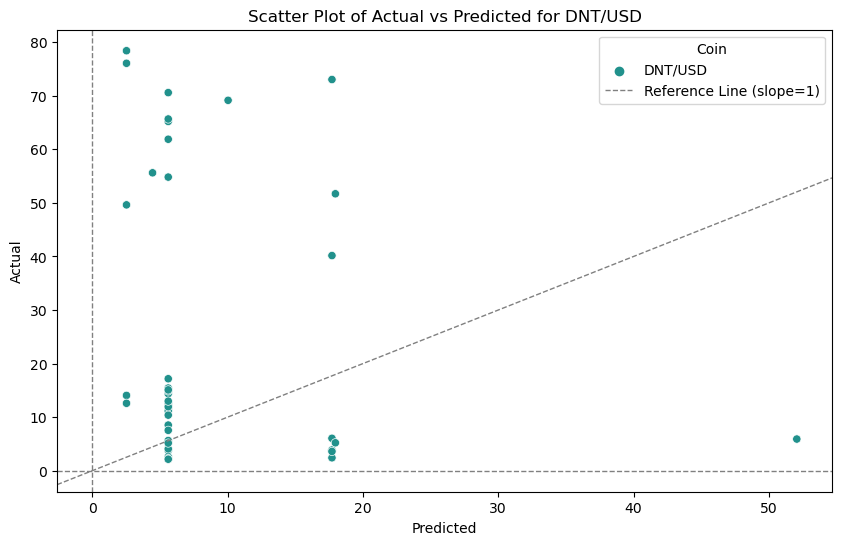

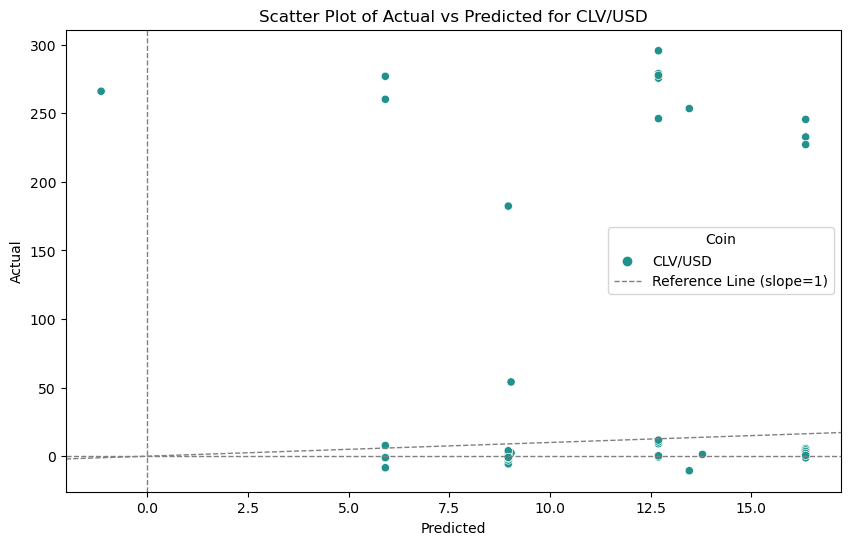

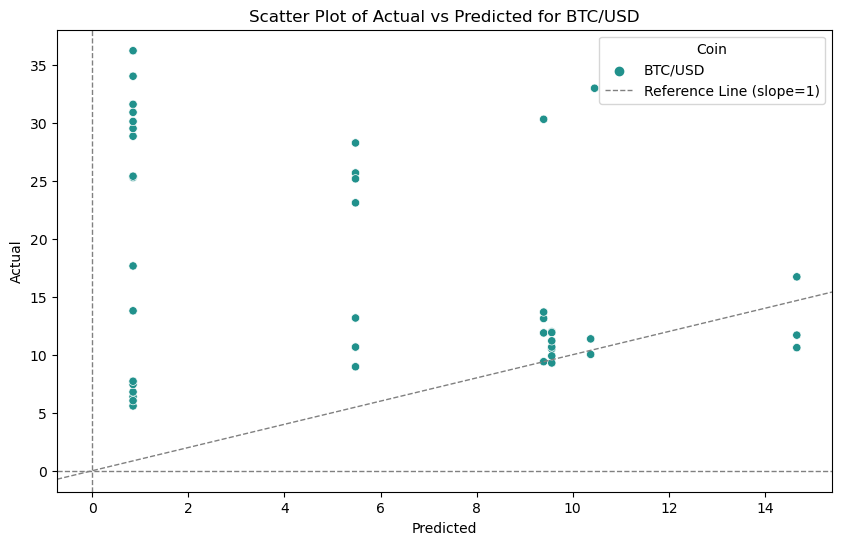

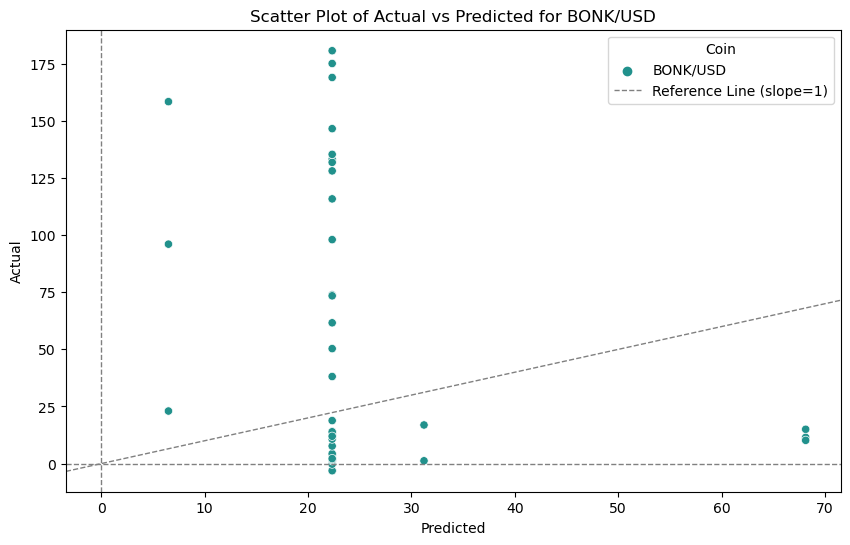

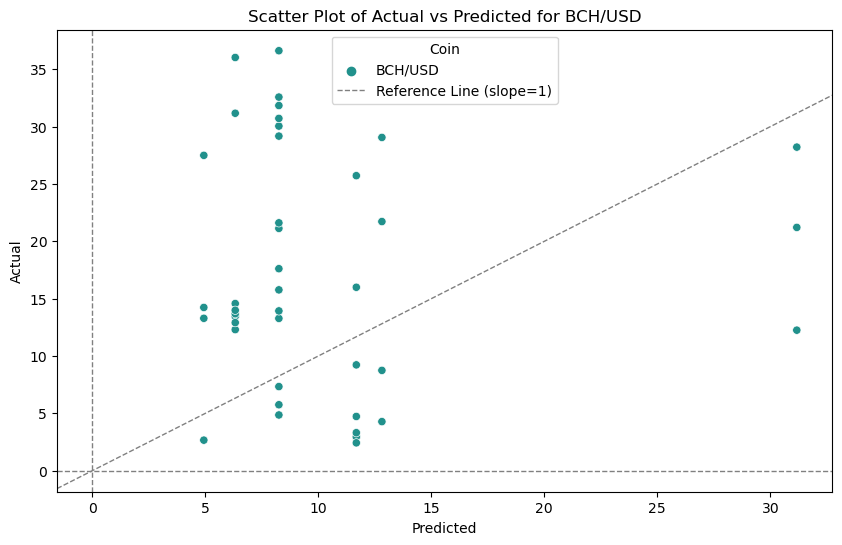

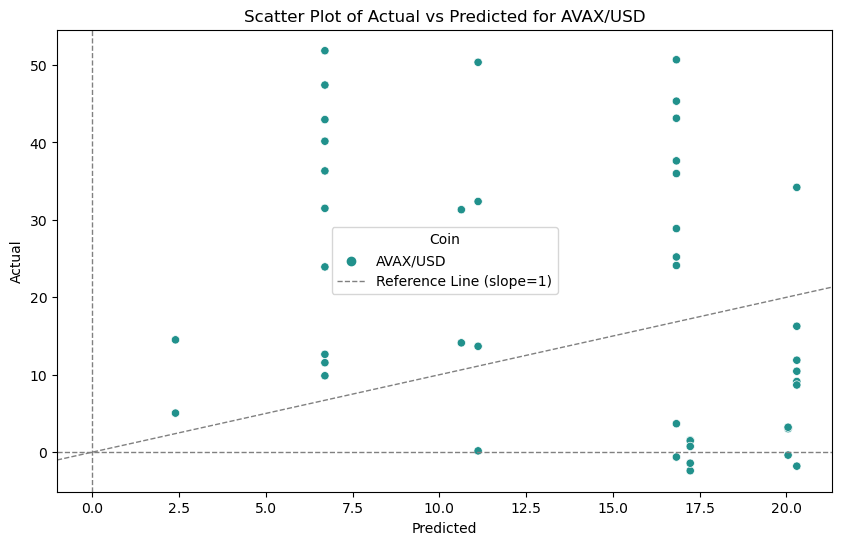

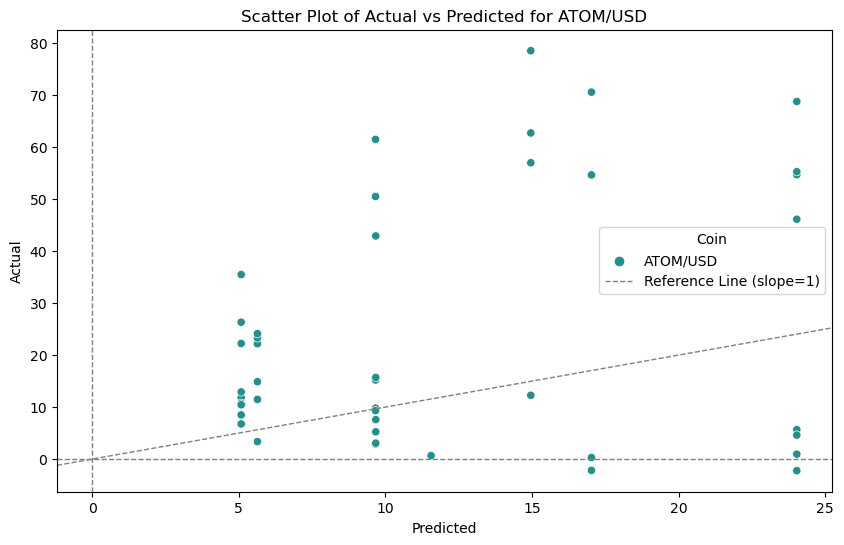

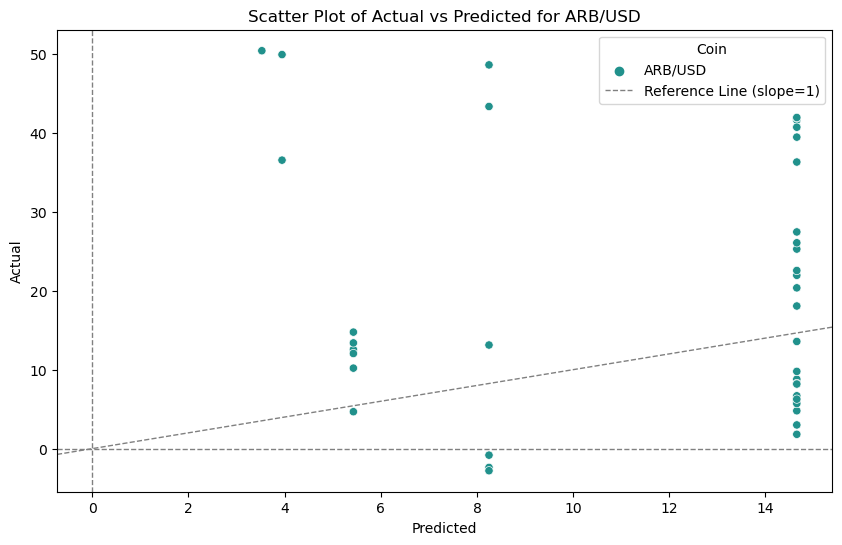

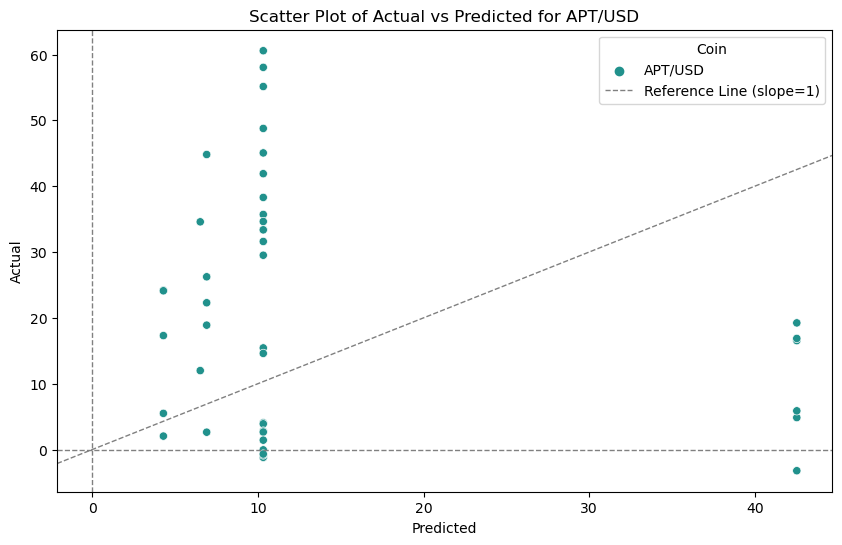

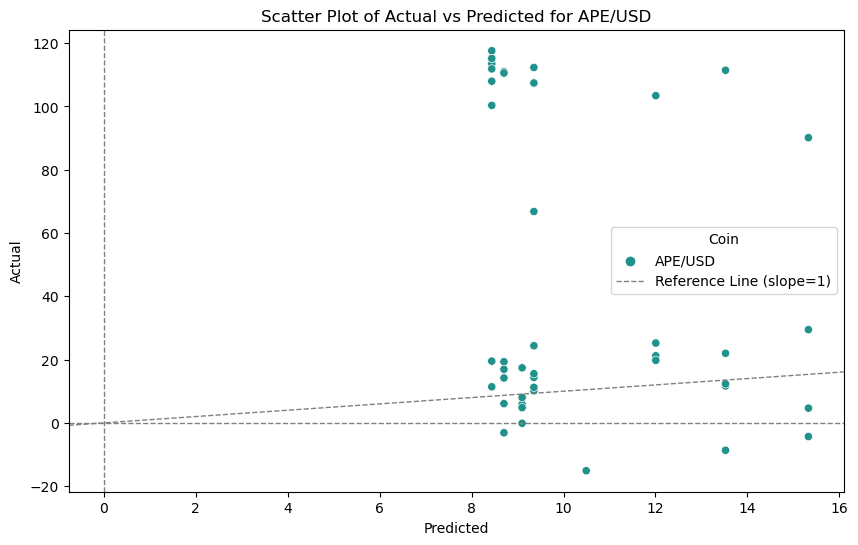

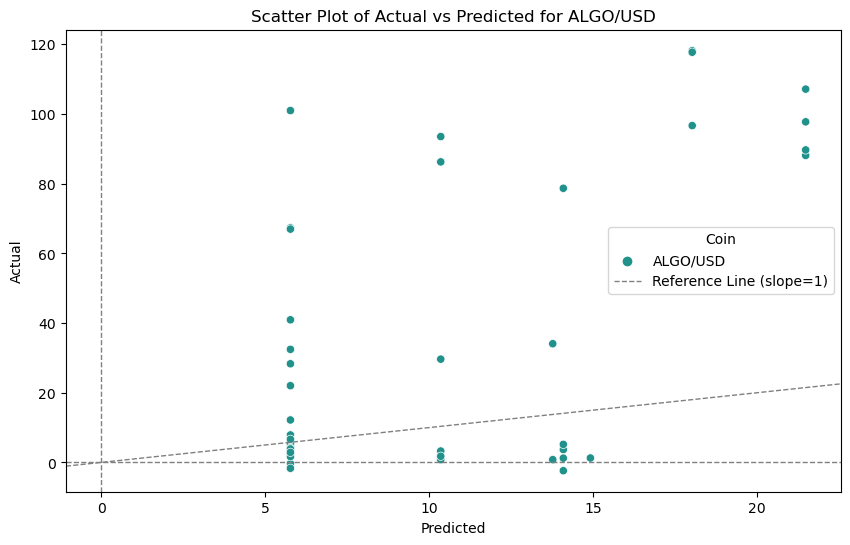

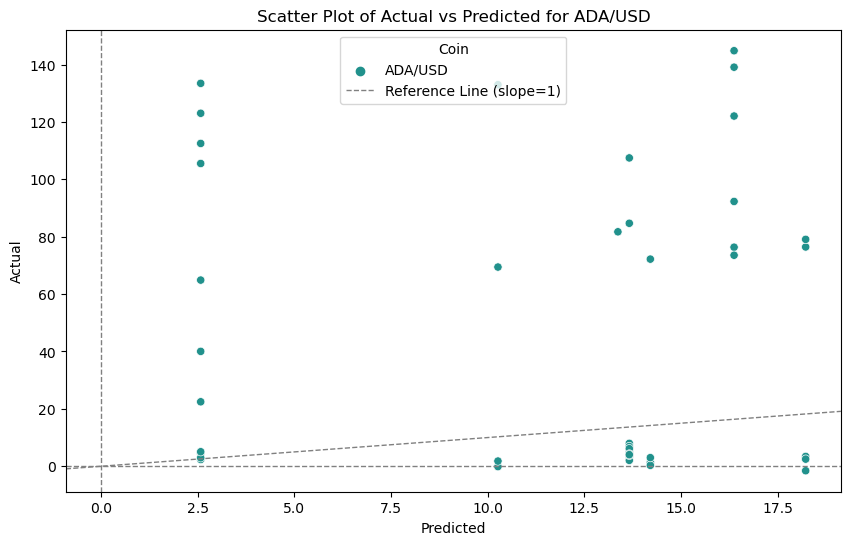

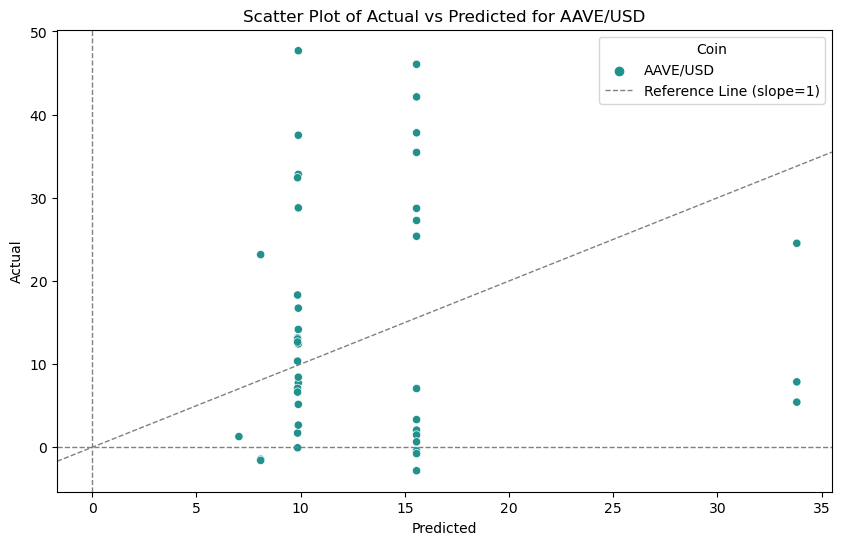

In [36]:
coins = df_test.loc[df_test.prediction_real != 0,'coin'].unique()
helper.plot_scatter(df_test, col_pred = 'prediction_real',coins = coins)

## Einfaches Entscheidungsbaummodell

In [37]:
dict_variables_tree = {}
for coin, model in models.items():
    importances = model.feature_importances_
    sorted_indices = importances.argsort()[::-1]
    dict_variables_tree[coin] = [(features[i], importances[i]) for i in sorted_indices[0:2]]

In [38]:
def train_test_tree(df_in, coin_sel, feat, targ, test_size_in):
        
    df_coin = df_in.loc[df_in.coin == coin_sel]     
    X = df_coin[feat]
    y = df_coin[targ]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Regressor
    model = DecisionTreeRegressor(random_state=42, max_depth=3)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate the model
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print(coin_sel)
    print(f'Train MAE: {train_mae}')
    print(f'Test MAE: {test_mae}')

    # Add predictions to the DataFrame for plotting
    df_test = X_test.copy()
    df_test['actual'] = y_test
    df_test['predicted'] = y_pred_test
    df_test['coin'] = coin_sel
    return model, df_test

# Initialize a dictionary to store models for each coin
trees = {}
df_results_tree = pd.DataFrame()
for coin_sel in df_model.coin.unique():
    model_i, df_res_i = train_test_tree(df_in=df_model, coin_sel=coin_sel, feat=[feat[0] for feat in dict_variables_tree[coin_sel]], targ=target, test_size_in=0.2)
    df_results_tree = pd.concat([df_results_tree, df_res_i])
    trees[coin_sel] = model_i

df_test_tree = df_test.copy()

# Calculate predictions for today
df_test_tree = df_test_tree.fillna(0)
df_test_tree['actual'] = df_test_tree[target]
df_test_tree.loc[:, 'predicted'] = np.nan
# Get predictions from each model
for coin_i, model_i in models.items():
    X_test = df_test_tree.loc[df_test_tree.coin == coin_i, features]
    df_test_tree.loc[df_test_tree.coin == coin_i, 'predicted'] = model_i.predict(X_test)
df_test_tree = df_test_tree.loc[df_test_tree[target] != 0]

XRP/USD
Train MAE: 4.782077066272431
Test MAE: 5.402524659400991
XLM/USD
Train MAE: 8.45468918006354
Test MAE: 8.538041935019798
VET/USD
Train MAE: 9.219961818884029
Test MAE: 9.480909741246496
UNI/USD
Train MAE: 11.049006208694026
Test MAE: 10.87867349871262
TIA/USD
Train MAE: 11.833275909841817
Test MAE: 13.858371612150872
SUI/USD
Train MAE: 12.08971408907064
Test MAE: 15.361764304394324
SOL/USD
Train MAE: 13.715955814520258
Test MAE: 13.953880786544575
SEI/USD
Train MAE: 16.857869062464015
Test MAE: 18.95749398541987
SD/USD
Train MAE: 1.2292198407266077
Test MAE: 2.2364069589291717
SAND/USD
Train MAE: 8.376858583616153
Test MAE: 8.870400543356793
QNT/USD
Train MAE: 11.747569858431616
Test MAE: 10.385860489919946
OP/USD
Train MAE: 14.143208423634768
Test MAE: 18.93514667713492
NEAR/USD
Train MAE: 12.403848676460662
Test MAE: 14.254691755009565
MKR/USD
Train MAE: 10.5514841809749
Test MAE: 11.29097253119224
MATIC/USD
Train MAE: 12.748200388898546
Test MAE: 14.304111731770778
MATH/USD


In [39]:
# Create bins for predicted values
bins = [-np.inf, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6,7,8,9,10, np.inf]
labels = ['<-5', '-5 to -4', '-4 to -3', '-3 to -2', '-2 to -1', '-1 to 0', '0 to 1', '1 to 2', '2 to 3', '3 to 4', '4 to 5', 
          '5 to 6','6 to 7', '7 to 8', '8 to 9', '9 to 10', '>10']
df_test_tree['pred_bins'] = pd.cut(df_test_tree['predicted'], bins=bins, labels=labels)

# Calculate average actual values per prediction bin
average_actual_per_bin = df_test_tree.groupby(['coin', 'pred_bins'])['actual'].agg(['count','min', 'max', 'median', 'mean']).reset_index()
for c in average_actual_per_bin['coin'].unique():
    print(c)
    print(average_actual_per_bin.loc[average_actual_per_bin['coin'] == c])

AAVE/USD
        coin pred_bins  count       min        max     median       mean
0   AAVE/USD       <-5      0       NaN        NaN        NaN        NaN
1   AAVE/USD  -5 to -4      0       NaN        NaN        NaN        NaN
2   AAVE/USD  -4 to -3      0       NaN        NaN        NaN        NaN
3   AAVE/USD  -3 to -2      0       NaN        NaN        NaN        NaN
4   AAVE/USD  -2 to -1      0       NaN        NaN        NaN        NaN
5   AAVE/USD   -1 to 0      0       NaN        NaN        NaN        NaN
6   AAVE/USD    0 to 1      0       NaN        NaN        NaN        NaN
7   AAVE/USD    1 to 2      0       NaN        NaN        NaN        NaN
8   AAVE/USD    2 to 3      0       NaN        NaN        NaN        NaN
9   AAVE/USD    3 to 4      0       NaN        NaN        NaN        NaN
10  AAVE/USD    4 to 5      1  1.285658   1.285658   1.285658   1.285658
11  AAVE/USD    5 to 6      3 -1.583346  23.167076  -1.442169   6.713854
12  AAVE/USD    6 to 7     10 -0.059892  3

In [40]:
df_application.loc[:, 'predicted'] = np.nan
# Get predictions from each model
for coin_i, model_i in models.items():
    X_application = df_application.loc[df_application.coin == coin_i, features]
    try:
        df_application.loc[df_application.coin == coin_i, 'predicted'] = model_i.predict(X_application)
    except:    
        df_application.loc[df_application.coin == coin_i, 'predicted'] = np.nan

In [41]:
df_application[['coin', 'predicted']].sort_values('predicted', ascending = False)

coin  predicted
40100    DOT/USD  35.879064
41508    TIA/USD  35.046631
39926  MATIC/USD  30.836458
41566    FLR/USD  28.523886
40796    ARB/USD  27.793202
39636    FET/USD  25.210513
40506    UNI/USD  24.890648
41450    SEI/USD  24.774726
40332    XLM/USD  21.997859
41392     OP/USD  19.800444
40274    GRT/USD  17.453667
39694   NEAR/USD  16.857954
41028    CLV/USD  16.531190
41624    HNT/USD  16.159709
40854    IMX/USD  12.579015
40680    APE/USD  11.073471
40390   ALGO/USD  10.712481
41334   ATOM/USD  10.425037
39462    ETH/USD  10.122324
41276    VET/USD   9.695990
41202   SAND/USD   9.633422
40042    ADA/USD   9.432766
39752   LINK/USD   8.654927
39810   AAVE/USD   8.420821
39868   AVAX/USD   8.118507
40448    MKR/USD   8.049983
41682   KAVA/USD   7.286410
39520    SOL/USD   6.680190
40622   MATH/USD   5.734908
40738    APT/USD   5.498457
40216    BCH/USD   3.123944
41144    QNT/USD   3.037977
39984    LTC/USD   2.879606
40912    DNT/USD   2.214230